In [1]:
%run 00_analysis_config.ipynb

Welcome to JupyROOT 6.24/06


In [2]:
# modules in this directory
import visualization, util, event, cutflow, detector
importlib.reload(event)
importlib.reload(visualization)
importlib.reload(util)
importlib.reload(detector)
import visualization as vis


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [10]:
import lsfit
reload(lsfit)
from lsfit import *

import include_modules_root as rt
import Kalman_tom

In [4]:
# Figure configuration are saved in this file include_figure_preset.py
from include_figure_preset import * 
# Set Figure font family, fontsize, ticks, etc.
plt_config(family="san-serif", fontsize_multi=1) # or "serif", or an exact font name

# Redefine a function to save figures with common settings 
fig_prefix = "plots/singletrack_"    # It's good to keep figures in a separate folder. Can also be set to None.
fig_format = "jpg"      # for multiple formats, e.g.: "pdf,png"
SAVE_FIG = False         # Use this flag to turn the figure saving on or off, so that you don't need to modify all notebook to save figure.
# You can then do `savefig(filename_without_extension)` to save your plots with these settings
savefig = Save_fig(fig_prefix=fig_prefix, exts=fig_format, SAVE= SAVE_FIG, dpi=300)

## Input file, output filenames, etc

In [12]:
# DATA_DIR    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
files=glob.glob(f"{DATA_DIR}/pion_10_GeV/*/*/stat_seedmod.root",)
print(files)
file_prefix=os.path.dirname(files[0])
tree_name="integral_tree"

filename = files[0]

['/project/def-mdiamond/tomren/mathusla/data/fit_study/pion_10_GeV/20230412/175710/stat_seedmod.root']


## First, look at what events we are dealing with

['NumHits', 'Hit_energy', 'Hit_time', 'Hit_detId', 'Hit_particlePdgId', 'Hit_G4TrackId', 'Hit_G4ParentTrackId', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_particleEnergy', 'Hit_particlePx', 'Hit_particlePy', 'Hit_particlePz', 'Digi_numHits', 'Digi_time', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_energy', 'Digi_px', 'Digi_py', 'Digi_pz', 'Digi_particle_energy', 'Digi_pdg_id', 'Digi_seed', 'GenParticle_index', 'GenParticle_G4index', 'GenParticle_pdgid', 'GenParticle_time', 'GenParticle_x', 'GenParticle_y', 'GenParticle_z', 'GenParticle_energy', 'GenParticle_px', 'GenParticle_py', 'GenParticle_pz', 'GenParticle_mass', 'G4KLong_code', 'EXTRA_12', 'EXTRA_13', 'EXTRA_14', 'EXTRA_15', 'Vertex_k_m_t', 'Vertex_k_m_x', 'Vertex_k_m_y', 'Vertex_k_m_z', 'Vertex_k_m_ErrorT', 'Vertex_k_m_ErrorX', 'Vertex_k_m_ErrorY', 'Vertex_k_m_ErrorZ', 'vertex_k_m_chi2', 'Vertex_k_m_trackIndices', 'NumVertices_k_m', 'Track_k_m_velX', 'Track_k_m_velY', 'Track_k_m_velZ', 'Track_k_m_x0', 'Track_k_m_y0', 'Track_k_m_z0', 'Track_k_m_t0',

findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


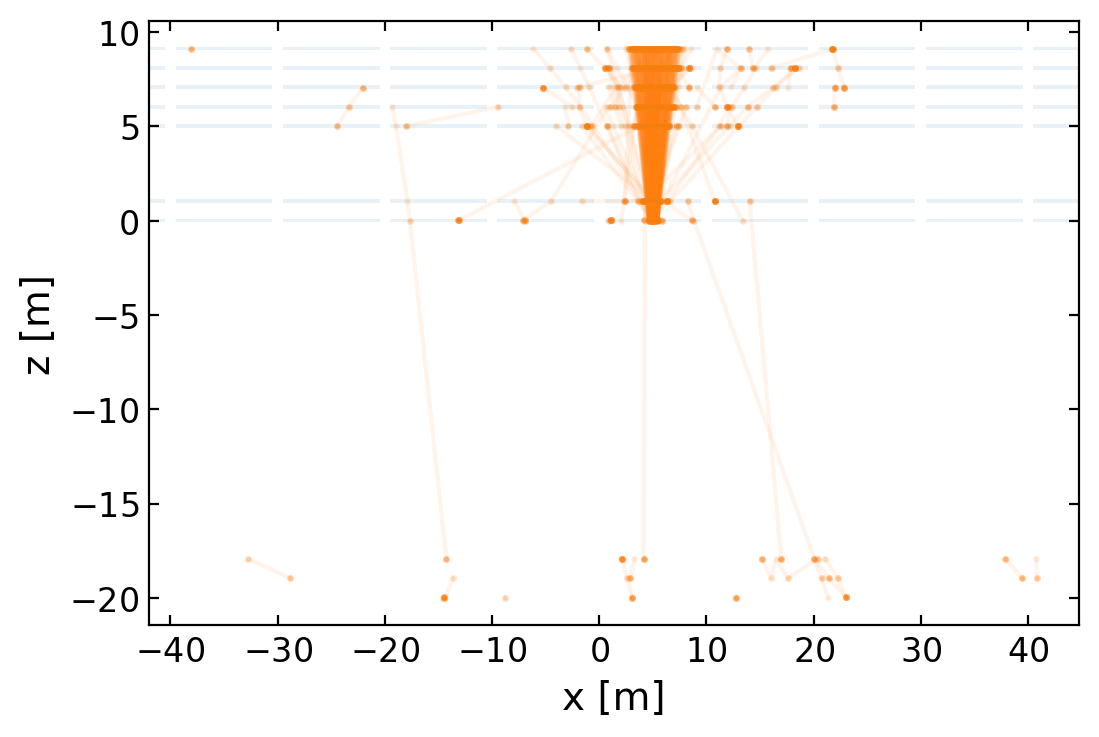

In [6]:
tfile = root.TFile.Open(filename)
Tree = tfile.Get(tree_name)

barnches = Tree.GetListOfBranches()
nevents = int(Tree.GetEntries())
branch_list = [barnches[i].GetName() for i in range(len(barnches))]
print(branch_list)

ev = event.Event(filename, 0, tree_name=tree_name)
# for i in range(nevents):
for i in range(300):
# for i in [8,9]:
#     ev = event.Event(filename, i, tree_name=tree_name)
    ev.EventNumber=i

    tracks=ev.get_truthtrack()
    if len(tracks)>0:
        for track in tracks:
            track=util.coord_cms2det(track)
            # plt.plot(track[0],track[2],marker=".",color="grey",alpha=0.1)
            plt.plot(track[0],track[2],marker=".",color="C1",alpha=0.08,markersize=3)    
        
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')
    
vis.drawdet_xz()
savefig("muon_eventview_300")

In [67]:
# for i_event in range(100):
#     ev.EventNumber=i_event
#     ev.Tree.GetEntry(i_event)
#     pdgids = np.array([ev.Tree.Hit_particlePdgId[i] for i in range(len(ev.Tree.Hit_particlePdgId))])

#     ind_secondary = int(np.argmax(pdgids!=pdgids[0]))
#     y_secondary = ev.Tree.Hit_y[ind_secondary-1]
#     print(y_secondary)

In [13]:
def get_km(filename, results_fit, tree_name):
    results_fit["par_km"]=[]
    results_fit["par_km_error"]=[]
    results_fit["par_km_truth"]=[]
    results_fit["par_km_ndigi"]=[]
    results_fit["par_km_inds"]=[]
    results_fit["y_primary"]=[]
    
    ev = event.Event(filename, 0, tree_name=tree_name)
    nevents = int(ev.Tree.GetEntries())
    cut=cutflow.sample_space("")


    for i_event in tqdm(range(nevents)):
        ev.EventNumber=i_event
        ev.Tree.GetEntry(i_event)

        hits = get_digi_hits(ev)
        nhits=len(ev.Tree.Hit_x)
        
        # Use Try to only process events with kalman reconstruction
        try:
            digi_hit_inds = util.unzip(ev.Tree.Track_k_m_hitIndices)
            digi_hit_len = np.array([len(i) for i in digi_hit_inds])
            track_ind = int(np.argmax(digi_hit_len==7))
            track_hits_inds=digi_hit_inds[track_ind]   
            hits_fit=np.array(hits)[track_hits_inds]
        
            par_km =[ev.Tree.Track_k_m_x0[track_ind], ev.Tree.Track_k_m_y0[track_ind], ev.Tree.Track_k_m_z0[track_ind], ev.Tree.Track_k_m_t0[track_ind], ev.Tree.Track_k_m_velX[track_ind], ev.Tree.Track_k_m_velY[track_ind], ev.Tree.Track_k_m_velZ[track_ind]]
            par_km_error =[ev.Tree.Track_k_m_ErrorX0[track_ind], ev.Tree.Track_k_m_ErrorY0[track_ind], ev.Tree.Track_k_m_ErrorZ0[track_ind], ev.Tree.Track_k_m_ErrorT0[track_ind], ev.Tree.Track_k_m_ErrorVx[track_ind], ev.Tree.Track_k_m_ErrorVy[track_ind], ev.Tree.Track_k_m_ErrorVz[track_ind]]
            xyz0_km = util.coord_cms2det(np.array(par_km[:3]))
            xyzV_km = np.array([par_km_error[2+4],par_km_error[0+4],-par_km_error[1+4]])
            
        except:
            continue    
            
#         times = [ev.Tree.Digi_time[i] for i in range(len(ev.Tree.Digi_time))]
        
#         ind_secondary = np.argmax(np.sign(np.diff(times))<0)            
        
#         if ind_secondary==0:
#             ndigi_primary =len(ev.Tree.Digi_x)
#         else:
#             ndigi_primary =ind_secondary-1

        pdgids = np.array([ev.Tree.Hit_particlePdgId[i] for i in range(len(ev.Tree.Hit_particlePdgId))])
        ind_secondary = int(np.argmax(pdgids!=pdgids[0]))
        y_secondary = ev.Tree.Hit_y[ind_secondary-1]
        y_layer = cut.in_layer(y_secondary)
        # pdgids = np.array([ev.Tree.Hit_particlePdgId[i] for i in range(len(ev.Tree.Hit_particlePdgId))])
        # ind_primary = np.flatnonzero(pdgids==pdgids[0])
        # y_primary = [ev.Tree.Hit_y[int(ii)] for ii in ind_primary]
        # y_layer1 = cut.in_layer(np.max(y_primary))
        # y_layer0 = cut.in_layer(np.min(y_primary))
        # truth_nlayer.append(y_layer1-y_layer0)   

        
        results_fit["y_primary"].append(y_layer)
            
            
        
        results_fit["par_km"].append(par_km)
        results_fit["par_km_error"].append(par_km_error)
        results_fit["par_km_ndigi"].append(len(track_hits_inds))
        results_fit["par_km_inds"].append(track_hits_inds)
        
        Tree=ev.Tree
        dt=Tree.Hit_time[1]-Tree.Hit_time[0]
        vx=(Tree.Hit_x[1]-Tree.Hit_x[0])/dt
        vy=(Tree.Hit_y[1]-Tree.Hit_y[0])/dt
        vz=(Tree.Hit_z[1]-Tree.Hit_z[0])/dt
        par_truth = [Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0], Tree.Hit_time[0],vx,vy,vz]
        results_fit["par_km_truth"].append(par_truth)        
        
    # results_fit["par_km"]=np.array(results_fit["par_km"])
    # results_fit["par_km_error"]=np.array(results_fit["par_km_error"])
    for key in results_fit:
        results_fit[key]=np.array(results_fit[key])
    
    
results_fit = {}    
get_km(filename, results_fit, tree_name)

100%|██████████| 40000/40000 [00:34<00:00, 1156.57it/s]
/tmp/ipykernel_223461/1878471282.py:78: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  results_fit[key]=np.array(results_fit[key])


In [15]:

# i_event=0
# ev.EventNumber=i_event
# ev.Tree.GetEntry(i_event)
# print(len(ev.Tree.Digi_x),ev.Tree.Track_k_m_hitIndices)

In [24]:
sum(results_fit["par_km_ndigi"]==(results_fit["y_primary"]-2))
mask_digi_correct= (results_fit["par_km_ndigi"]==(results_fit["y_primary"]-2))
for i in range(len(mask_digi_correct)):
    if np.any(results_fit["par_km_inds"][i] != np.arange(0, results_fit["par_km_ndigi"][i])):
        mask_digi_correct[i] = False

print(sum(mask_digi_correct))

27177


In [28]:
sum(results_fit["par_km_ndigi"]==(results_fit["y_primary"]-2))
mask_digi_correct= np.ones(len(results_fit["par_km_ndigi"]),dtype=bool)
for i in range(len(mask_digi_correct)):
    for j in results_fit["par_km_inds"][i]:
        if j not in np.arange(0, results_fit["par_km_ndigi"][i]):
        # if j not in np.arange(0, results_fit["y_primary"][i]-2):
            mask_digi_correct[i] = False
            break        

print(sum(mask_digi_correct))

28248


In [27]:
# print(sum(results_fit["y_primary"]<=5)+sum(results_fit["y_primary"]==999))
# mask=(results_fit["y_primary"]>5)&(results_fit["y_primary"]<=9)
mask=((results_fit["y_primary"]>=6)&(results_fit["y_primary"]<=9))&mask_digi_correct
np.sum(mask)

27315

In [23]:
27/35

0.7714285714285715

In [19]:
# --- Get the FWHM to apply a cut ---
plot_data = joblib.load(f"{DATA_DIR}/plot_data_pion_singletrack.jojblib")
plot_data_res = plot_data[0]    

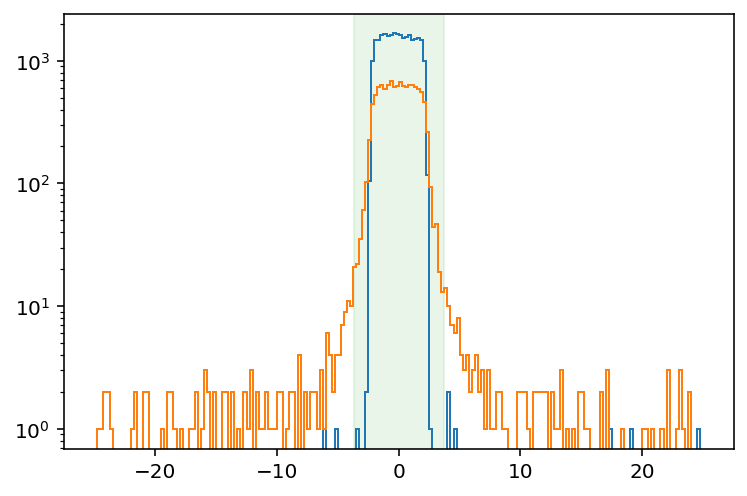

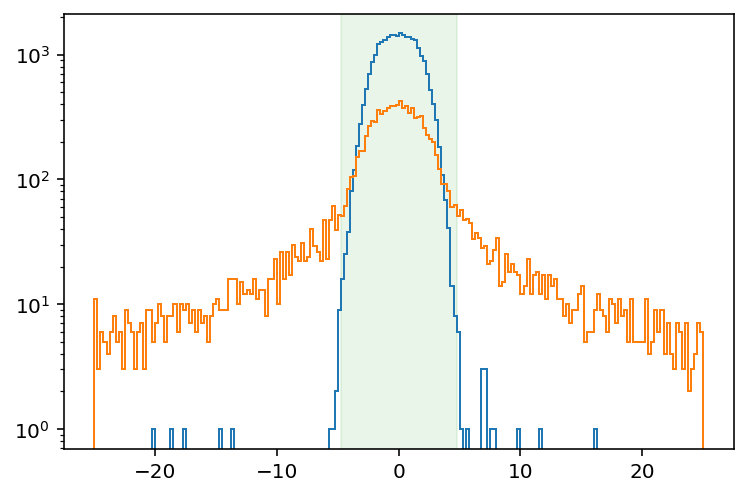

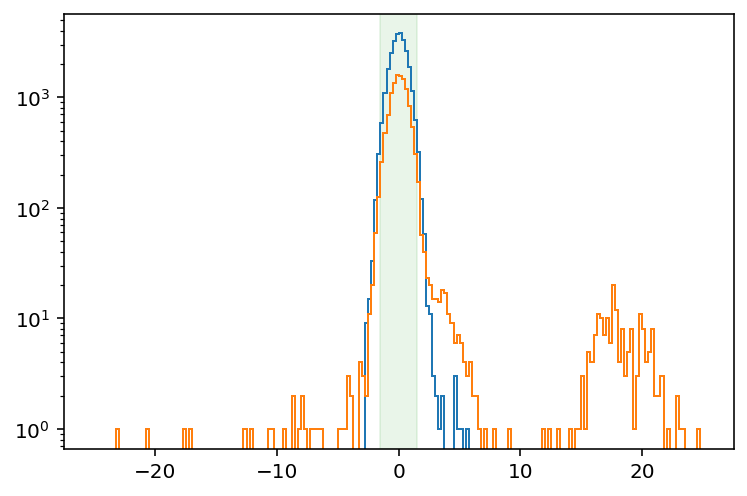

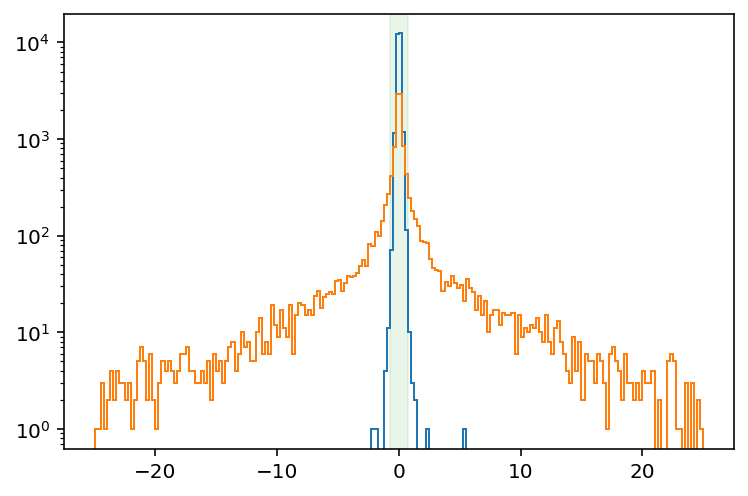

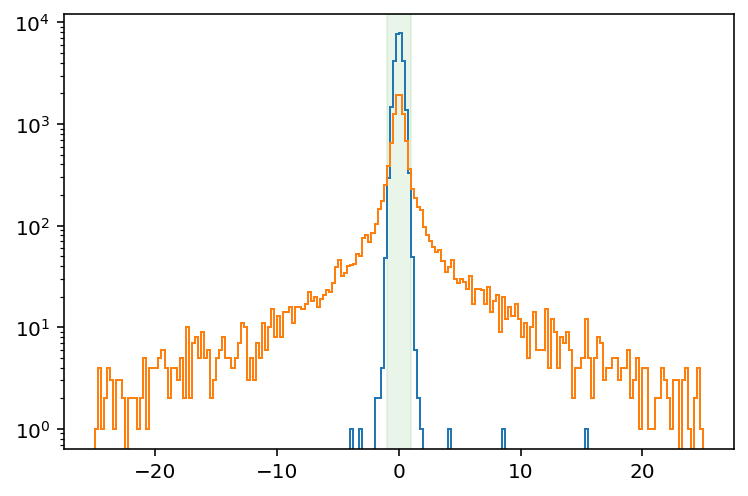

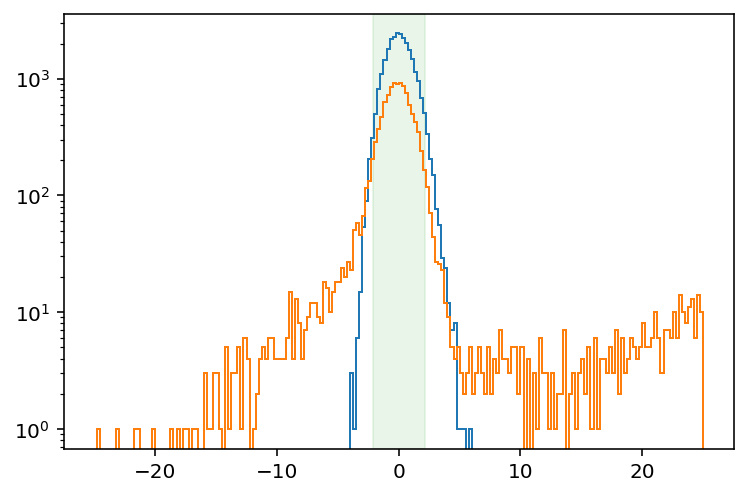

In [20]:
ifile=0

ipar=4
mask_2fwhm = np.ones(len(mask), dtype=bool)

inds_ipar = [2,0,3,6,4,5]

for ipar in range(6):
    residual_ls=results_fit["par_km"][:,inds_ipar[ipar]]-results_fit["par_km_truth"][:,inds_ipar[ipar]]

    hist(residual_ls[mask],range=(-25,25),histtype="step",label=f"2",bins=200);
    hist(residual_ls[~mask],range=(-25,25),histtype="step",label=f"2",bins=200);
    yscale("log")

    es,sigmas,fwhms = plot_data_res[ipar]
    mask_2fwhm = mask_2fwhm&(np.abs(residual_ls)<2*fwhms[ifile]*2.355)
    axvspan(-2*fwhms[ifile], 2*fwhms[ifile],alpha=0.1,color="C2")
    show()

In [74]:
sum(mask_2fwhm&mask)/sum(mask)

0.8557675119385071

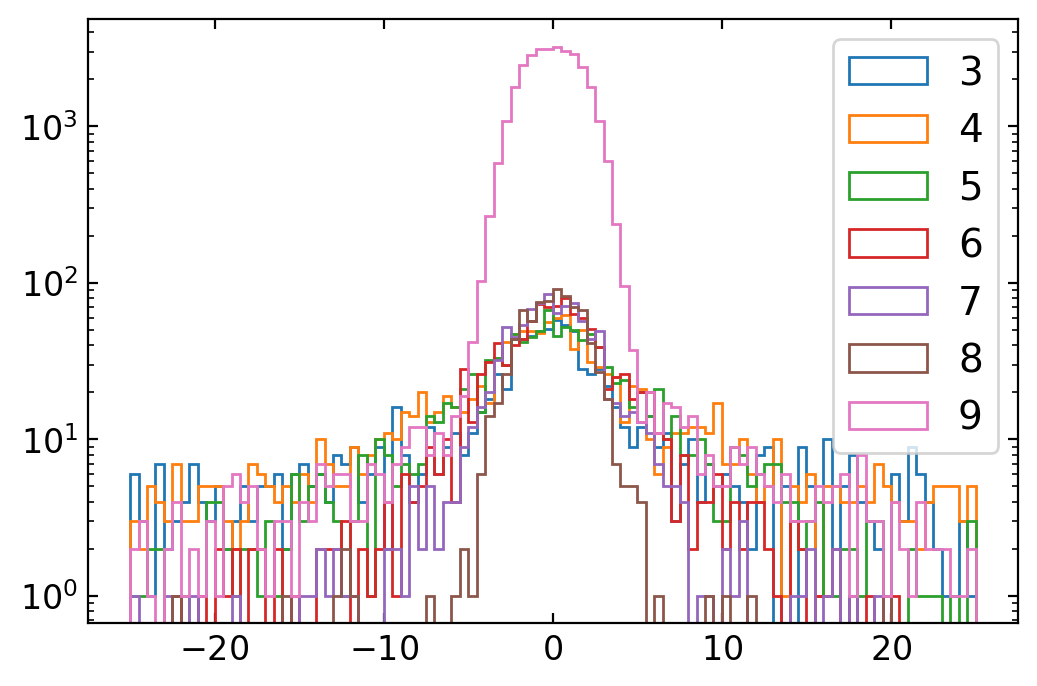

In [57]:
ipar=0
residual_ls=results_fit["par_km"][:,ipar]-results_fit["par_km_truth"][:,ipar]

# scatter(results_fit["y_primary"]-8500, residual_ls, alpha=0.01)
# xlim(0,1000)
# ylim(-15,15)

for layer in range(3,10):
    hist(residual_ls[results_fit["y_primary"]==layer],range=(-25,25),histtype="step",label=f"{layer}")
    
yscale("log")
legend()

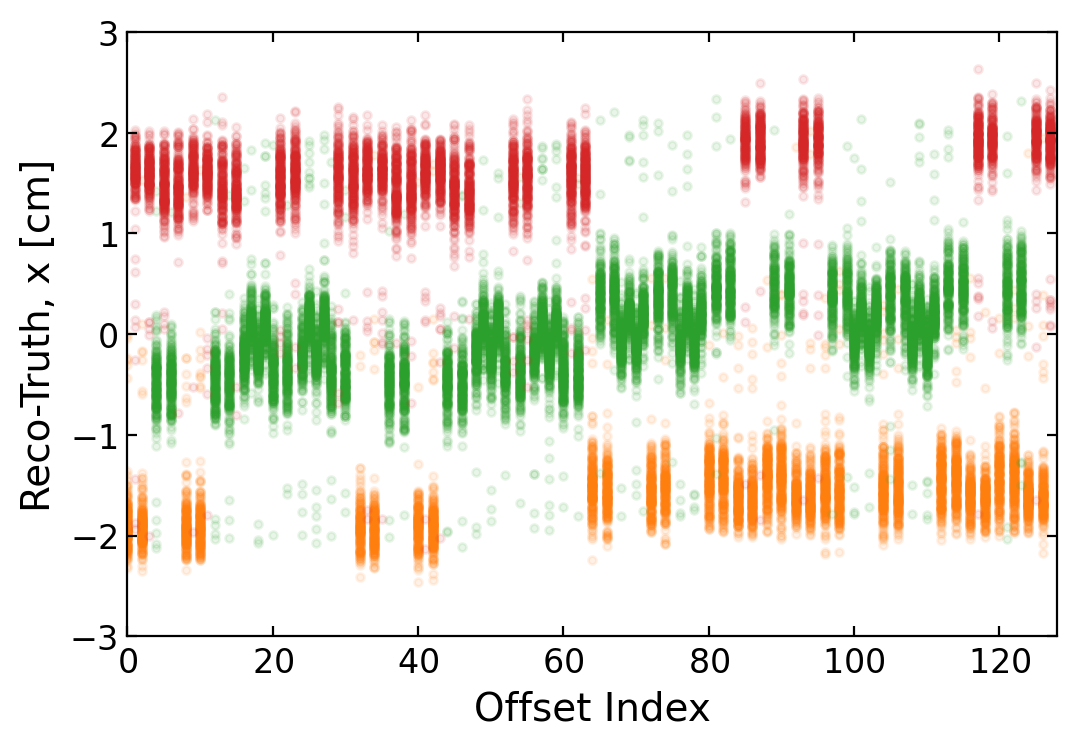

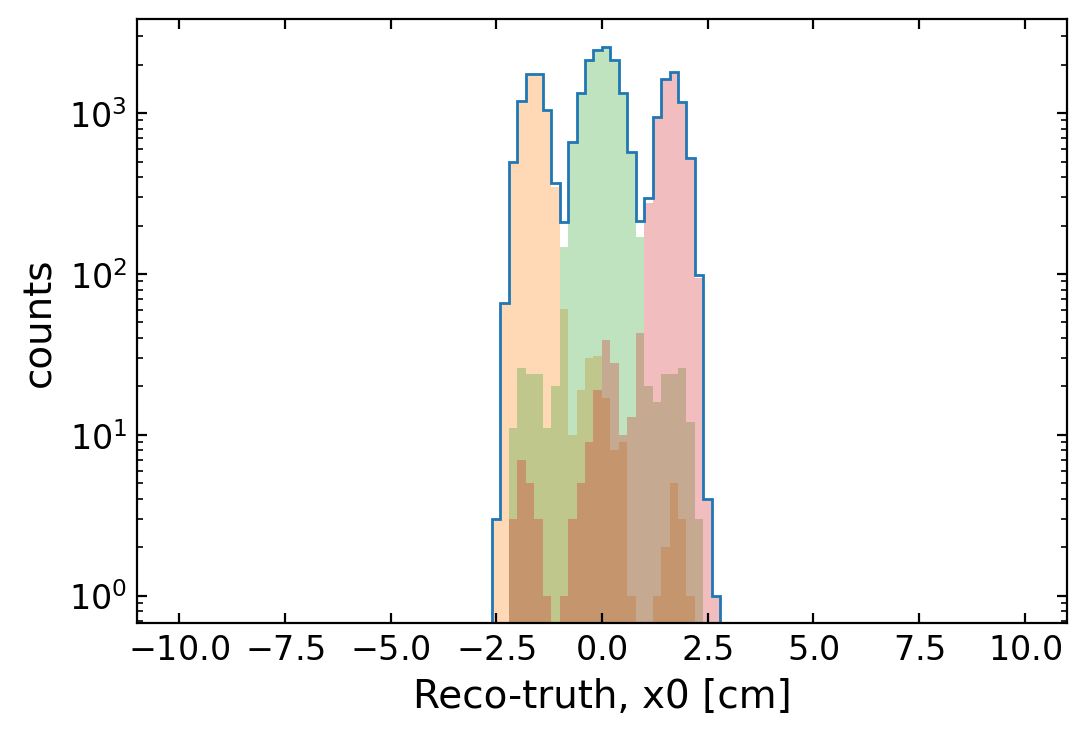

In [29]:
ipar=2
residual_ls=results_fit["par_fit"][:,ipar]-results_fit["par_truth"][:,ipar]
_range=(np.percentile(residual_ls,1)*2,np.percentile(residual_ls,99)*2)
_range=(-max(np.abs(_range))*2,max(np.abs(_range))*2)


plt.scatter(direction_masked[mask_7hits&mask_low], residual_ls[mask_7hits&mask_low],color="C1",s=8,alpha=0.1);#bins=np.linspace(360,500,100));
plt.scatter(direction_masked[mask_7hits&mask_mid], residual_ls[mask_7hits&mask_mid],color="C2",s=8,alpha=0.1);#bins=np.linspace(360,500,100));
plt.scatter(direction_masked[mask_7hits&mask_high], residual_ls[mask_7hits&mask_high],color="C3",s=8,alpha=0.1);#bins=np.linspace(360,500,100));

plt.xlabel("Offset Index")
plt.ylabel("Reco-Truth, x [cm]")
plt.xlim(0,128)
plt.ylim(-3,3)
savefig("offset_index")
plt.show()

residual_ls=results_fit["par_fit"][:,ipar]-results_fit["par_truth"][:,ipar]
_range=[-10,10]
n,ibins,_=plt.hist(residual_ls[mask_7hits],histtype="step",bins=100,range=_range);#bins=np.linspace(360,500,100));
plt.hist(residual_ls[mask_7hits&mask_low],alpha=0.3,color="C1",bins=100,range=_range);#bins=np.linspace(360,500,100));
plt.hist(residual_ls[mask_7hits&mask_mid],alpha=0.3,color="C2",bins=100,range=_range);#bins=np.linspace(360,500,100));
plt.hist(residual_ls[mask_7hits&mask_high],alpha=0.3,color="C3",bins=100,range=_range);#bins=np.linspace(360,500,100));
plt.xlabel(f"Reco-truth, x0 [cm]")
plt.ylabel("counts")
plt.yscale("log")
savefig("offset_index_hist")


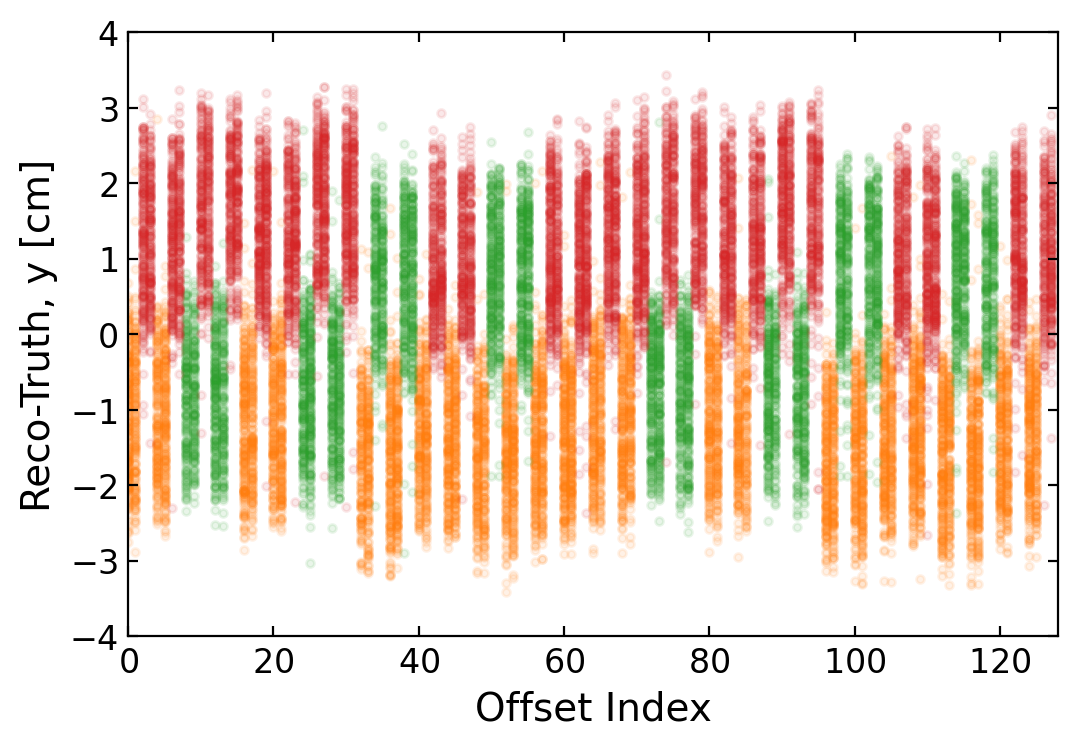

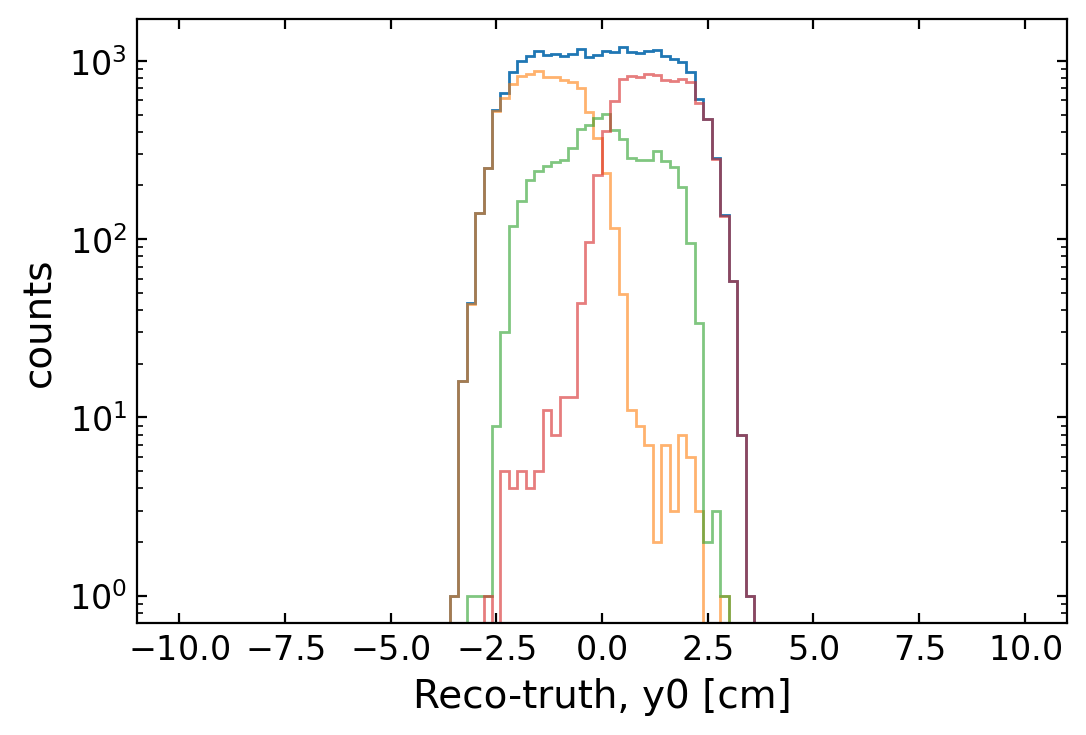

In [30]:
ipar=0
residual_ls=results_fit["par_fit"][:,ipar]-results_fit["par_truth"][:,ipar]
_range=(np.percentile(residual_ls,1)*2,np.percentile(residual_ls,99)*2)
_range=(-max(np.abs(_range))*2,max(np.abs(_range))*2)


plt.scatter(direction_masked[mask_7hits&mask_low_y], residual_ls[mask_7hits&mask_low_y],color="C1",s=8,alpha=0.1);#bins=np.linspace(360,500,100));
plt.scatter(direction_masked[mask_7hits&mask_mid_y], residual_ls[mask_7hits&mask_mid_y],color="C2",s=8,alpha=0.1);#bins=np.linspace(360,500,100));
plt.scatter(direction_masked[mask_7hits&mask_high_y], residual_ls[mask_7hits&mask_high_y],color="C3",s=8,alpha=0.1);#bins=np.linspace(360,500,100));

plt.xlabel("Offset Index")
plt.ylabel("Reco-Truth, y [cm]")
plt.xlim(0,128)
plt.ylim(-4,4)
savefig("offset_index_y")
plt.show()

residual_ls=results_fit["par_fit"][:,ipar]-results_fit["par_truth"][:,ipar]
_range=[-10,10]
n,ibins,_=plt.hist(residual_ls[mask_7hits],histtype="step",bins=100,range=_range);#bins=np.linspace(360,500,100));
plt.hist(residual_ls[mask_7hits&mask_low_y],alpha=0.6,histtype="step",color="C1",bins=100,range=_range);#bins=np.linspace(360,500,100));
plt.hist(residual_ls[mask_7hits&mask_mid_y],alpha=0.6,histtype="step",color="C2",bins=100,range=_range);#bins=np.linspace(360,500,100));
plt.hist(residual_ls[mask_7hits&mask_high_y],alpha=0.6,histtype="step",color="C3",bins=100,range=_range);#bins=np.linspace(360,500,100));
plt.xlabel(f"Reco-truth, y0 [cm]")
plt.ylabel("counts")
plt.yscale("log")
savefig("offset_index_hist_y")


In [31]:
# x=[0,1,2,4,5]
# y=[0,1,6,1,0]
# popt,pcov = rt.fit_tg(x,y,yerr=np.sqrt(y),function="gaus")

### Final plots 1: LS

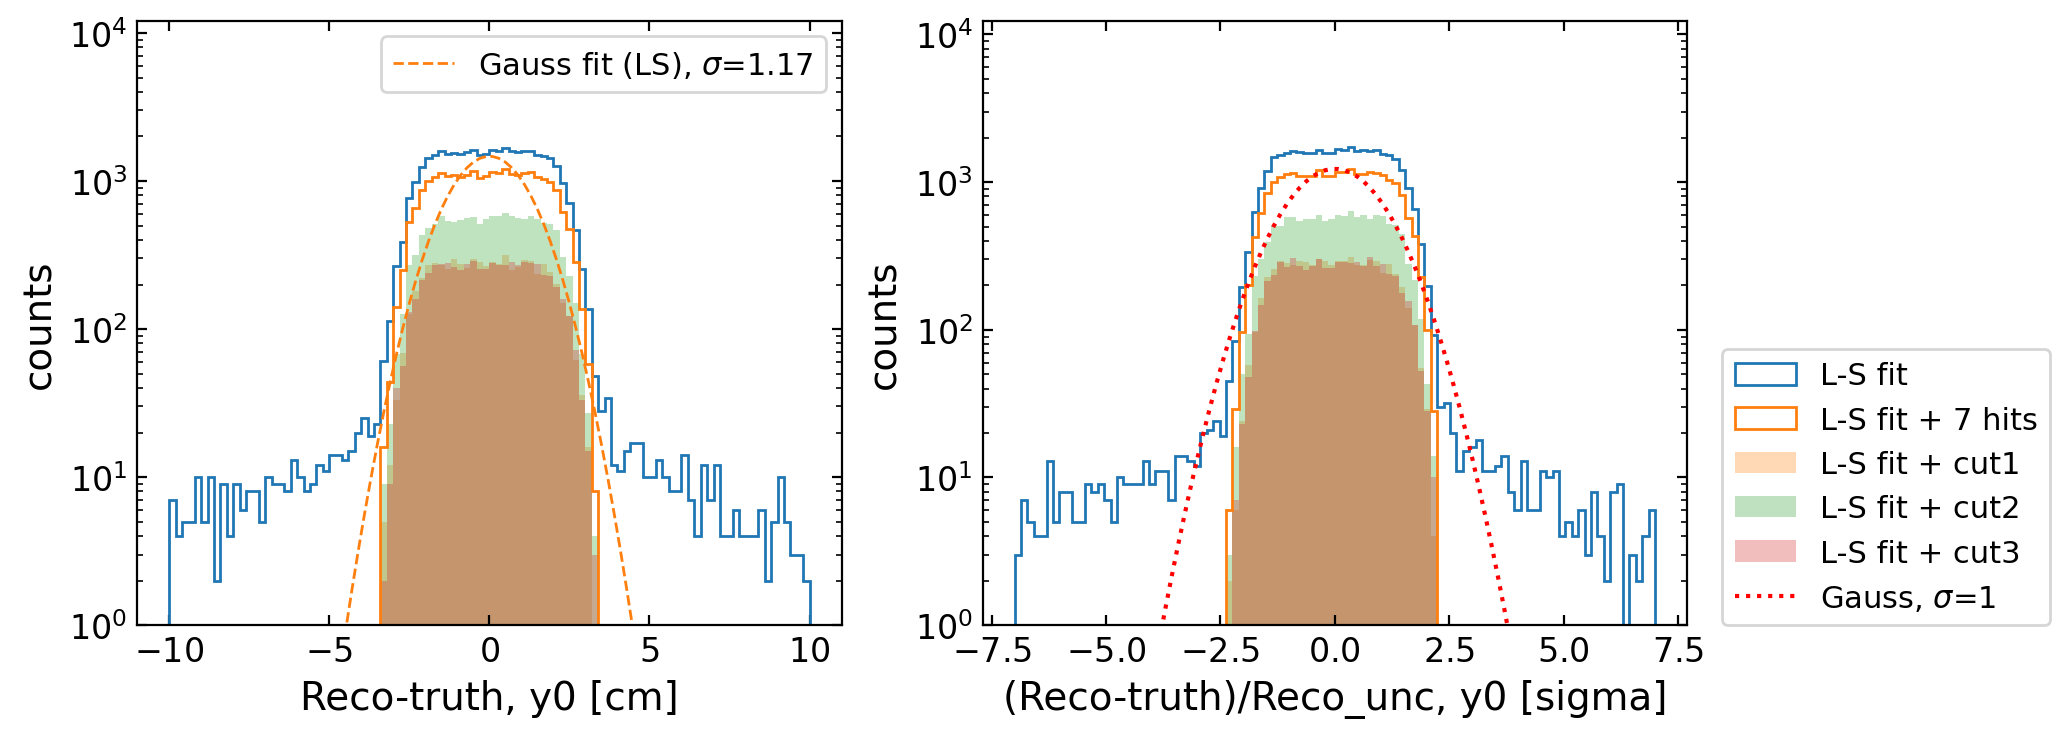

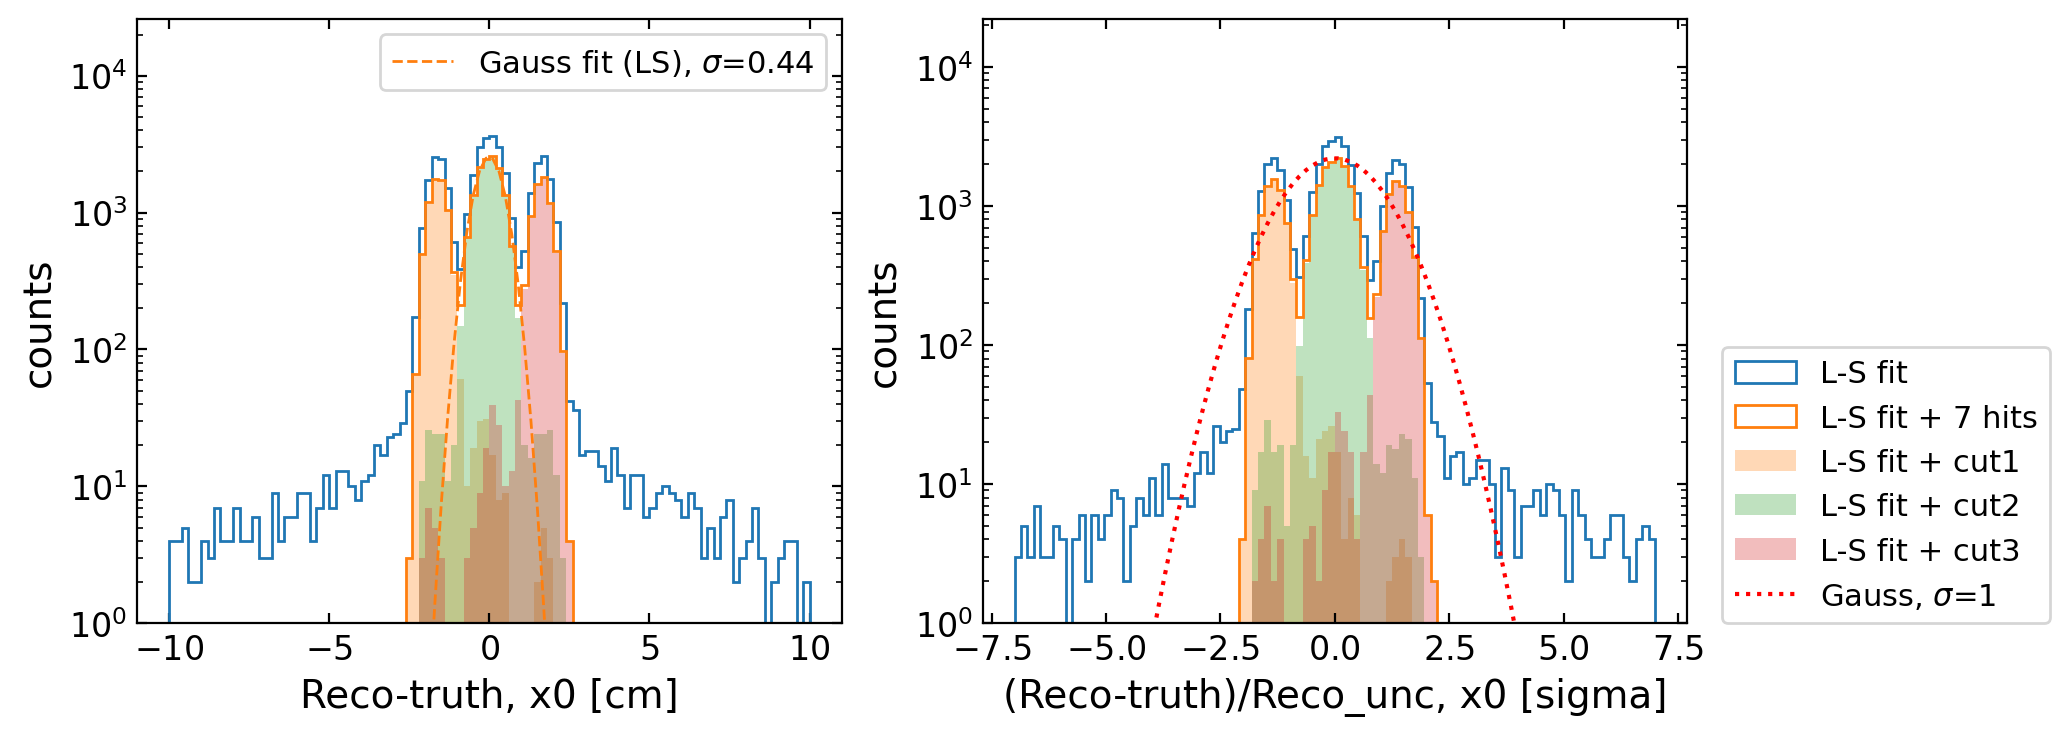

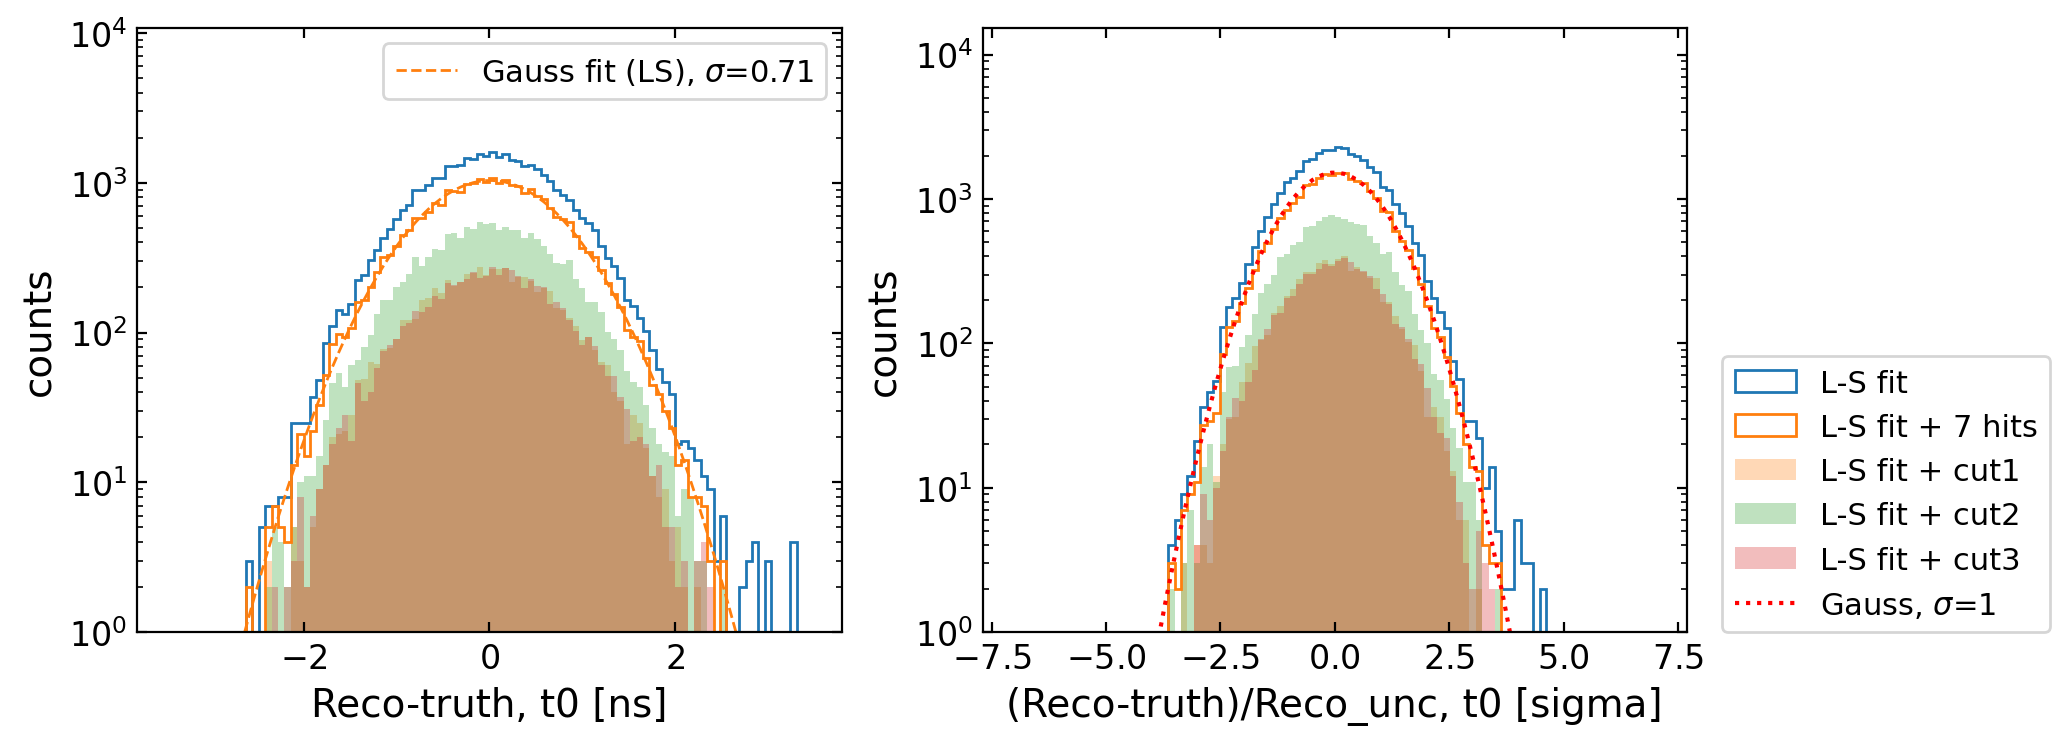

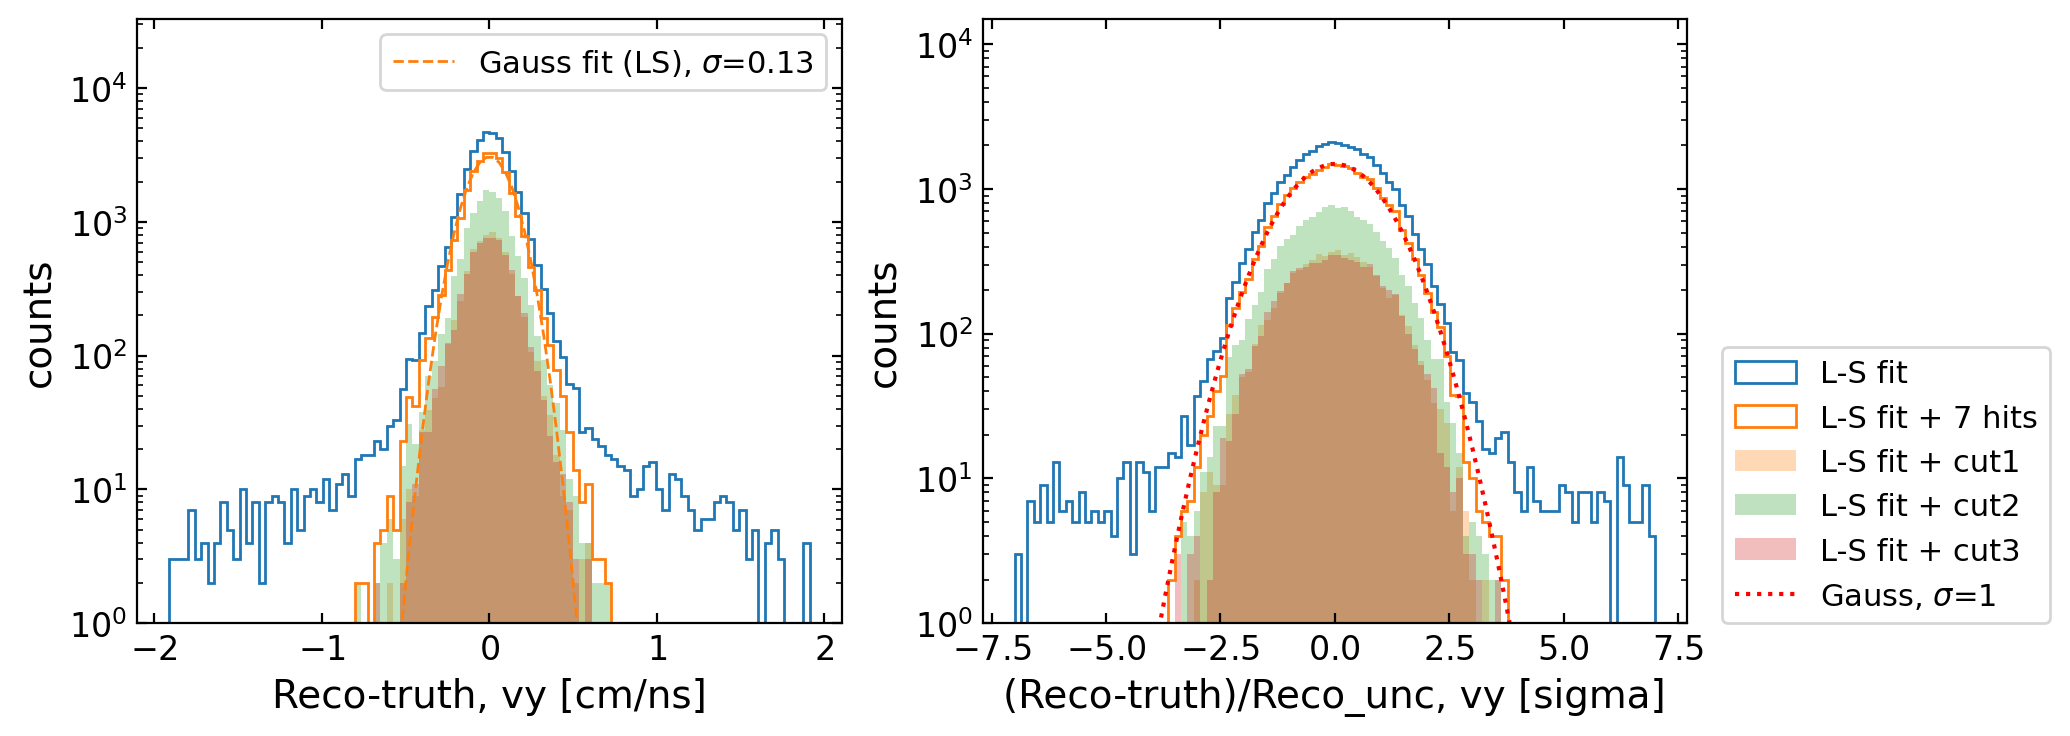

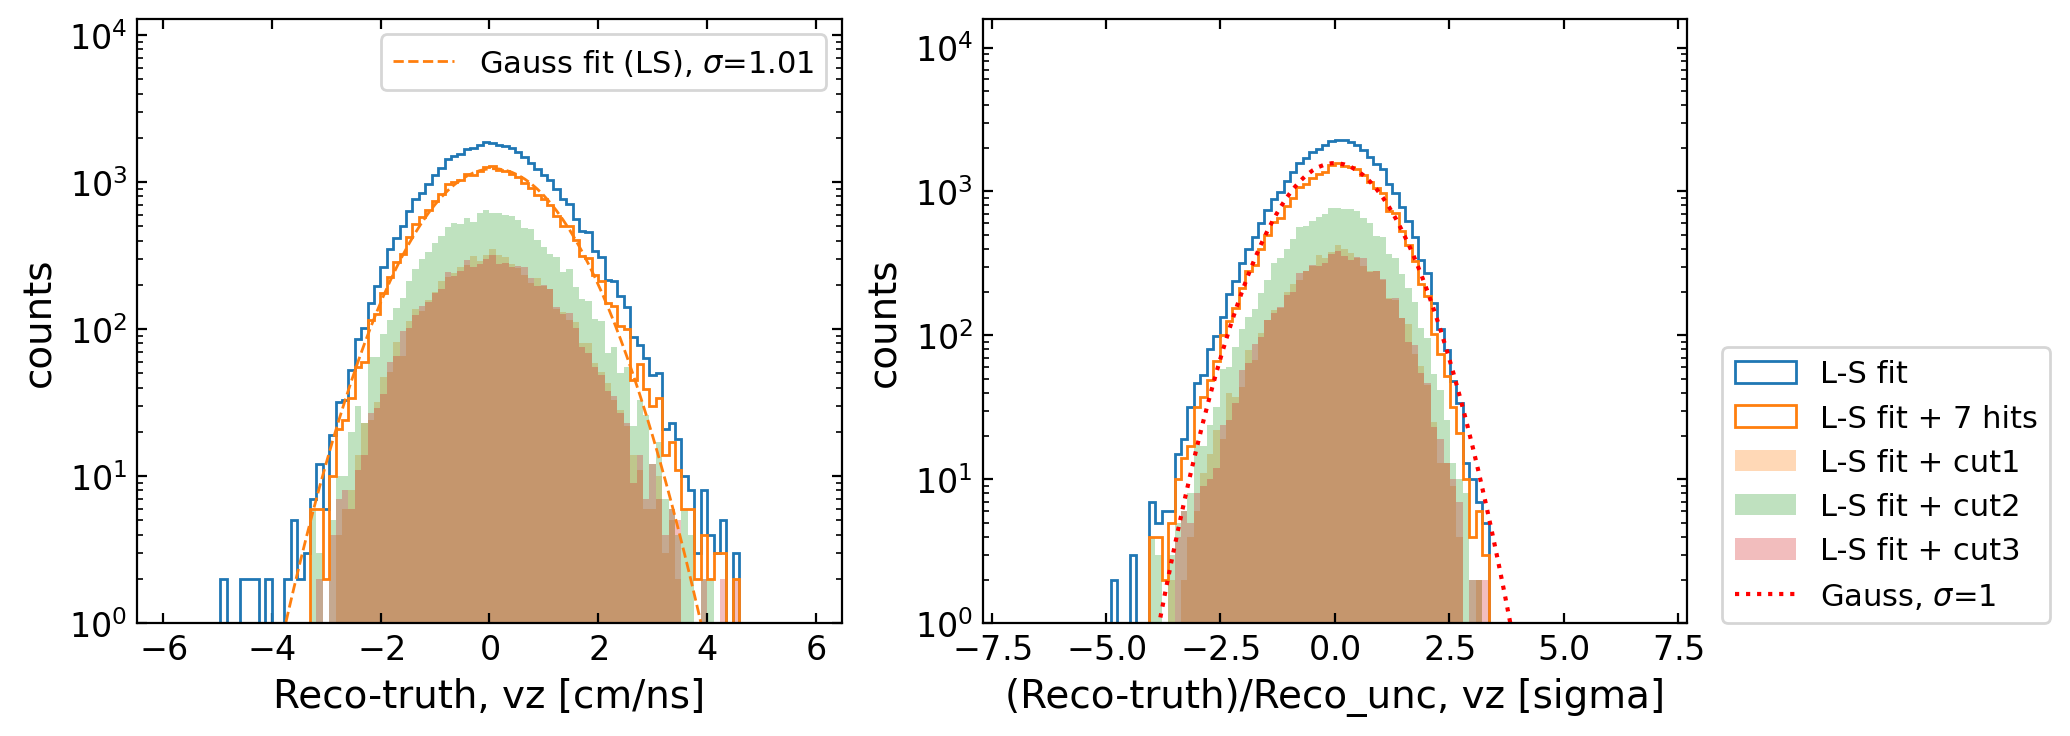

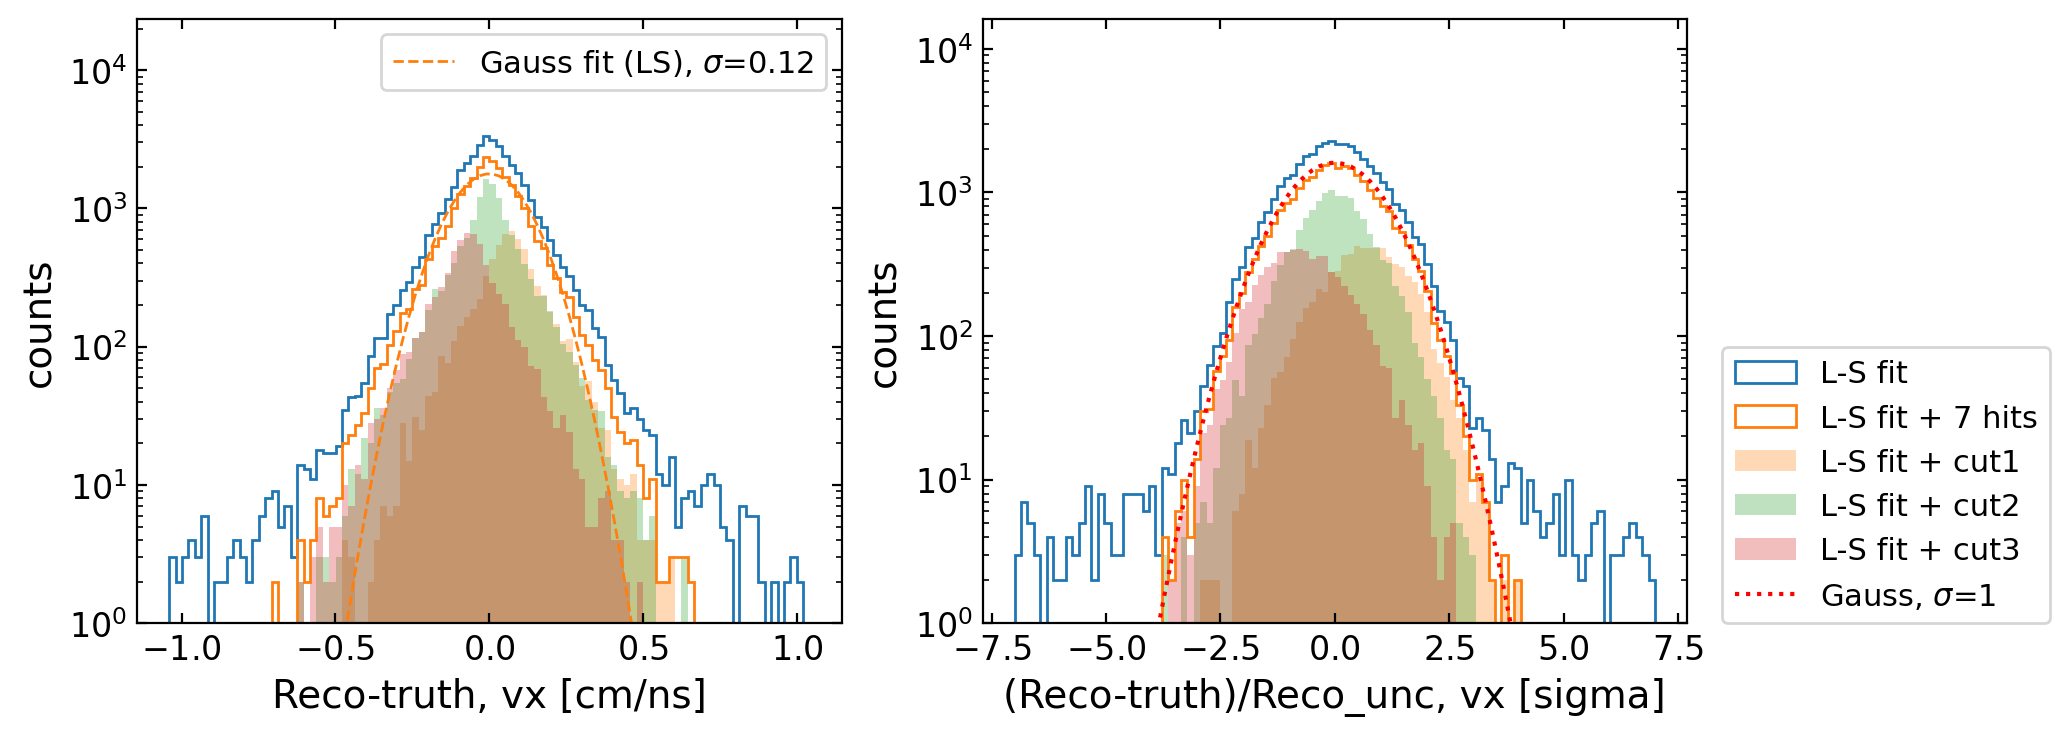

 FCN=5324.81 FROM MIGRAD    STATUS=CONVERGED      79 CALLS          80 TOTAL
                     EDM=8.97618e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.3 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.47051e+03   1.07298e+01   1.04600e-01  -8.15045e-07
   2  Mean         9.81475e-04   8.07402e-03  -1.98212e-05   1.32505e-02
   3  Sigma        1.16869e+00   3.11408e-03   1.81588e-06  -1.80422e-01
 FCN=12781.1 FROM MIGRAD    STATUS=CONVERGED     144 CALLS         145 TOTAL
                     EDM=1.05622e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.56020e+03   3.02958e+01   1.19283e+00  -2.00552e-05
   2  Mean        -5.53858e-03   3.69411e-03   2.03834e-04   4.11789e-02
   3  Sigma        4

In [32]:
par_names=['y0', 'z0', 'x0', 't0', 'vy', 'vz', 'vx'] # Use real world direction
par_unit= ["[cm]",'[cm]',"[cm]", "[ns]","[cm/ns]","[cm/ns]","[cm/ns]"]
# ranges=[(-20,20),(-20,20),(-20,20),(-20,20),(-30,30),(-30,30),(-30,30)]

for ipar in range(7):
    if ipar==1:
        continue
    #_range=ranges[ipar]
    residual_ls=results_fit["par_fit"][:,ipar]-results_fit["par_truth"][:,ipar]
    residual_km=results_fit["par_km"][:,ipar]-results_fit["par_truth"][:,ipar]
    _range=(np.percentile(residual_km,1)*2,np.percentile(residual_km,99)*2)
    _range=(-max(np.abs(_range)),max(np.abs(_range)))

#     if _range[1]>15:
#         _range=[-15,15]
    if ipar<=2:
        _range=[-10,10]

    def pull(x_measure, x_truth, x_unc):
        return (x_measure-x_truth)/x_unc
    pull_ls=pull(residual_ls,0,results_fit["par_fit_error"][:,ipar])
    pull_km=pull(residual_km,0,np.sqrt(results_fit["par_km_error"][:,ipar]))

    fig,axs=plt.subplots(1,2,figsize=(10,4))
    plt.sca(axs[0])
    plt.hist(residual_ls,histtype="step",bins=100,range=_range);#bins=np.linspace(360,500,100));
    n,ibins,_=plt.hist(residual_ls[mask_7hits],histtype="step",bins=100,range=_range);#bins=np.linspace(360,500,100));
    # plt.hist(residual_ls[mask_7hits&mask_noshare],histtype="step",bins=100,range=_range);#bins=np.linspace(360,500,100));
#     plt.hist(residual_km,histtype="step",bins=100,range=_range,label="KF, mod");#bins=np.linspace(360,500,100));
    plt.hist(residual_ls[mask_7hits&mask_low],alpha=0.3,color="C1",bins=100,range=_range);#bins=np.linspace(360,500,100));
    plt.hist(residual_ls[mask_7hits&mask_mid],alpha=0.3,color="C2",bins=100,range=_range);#bins=np.linspace(360,500,100));
    plt.hist(residual_ls[mask_7hits&mask_high],alpha=0.3,color="C3",bins=100,range=_range);#bins=np.linspace(360,500,100));
    # plt.hist(residual_km[mask],alpha=0.3,color="C1",bins=100,range=_range,label="KF, mod + cut");#bins=np.linspace(360,500,100));
    plt.xlabel(f"Reco-truth, {par_names[ipar]} {par_unit[ipar]}")
    plt.ylabel("counts")
    plt.yscale("log")
    
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    yerr=np.sqrt(n)
    yerr[yerr==0]=1
    popt,pcov = rt.fit_tg(bincenters,n,yerr=yerr,function="gaus")
    perr = np.sqrt(np.diag(pcov))
    fw = util.Utils.fwhm(bincenters, n)
    fwhm = fw[1]-fw[0]
    
    plt.plot(bincenters,util.Utils.Gauss(bincenters, *popt),color="C1",alpha=1,linewidth=1,
             linestyle="--",label=r"Gauss fit (LS), $\sigma$="+f"{popt[-1]:.2f}")
             # linestyle="--",label=r"Gauss fit (LS), $\sigma$="+f"{popt[-1]:.2f}"+r"$\pm$"+f"{perr[-1]:.2e}\n"+f"FWHM={fwhm:.2f}, FWHM/2.35={fwhm/2.35:.2f}")
    plt.legend(fontsize=11)
    plt.ylim(1,max(n)*10)
    

    plt.sca(axs[1])
    _range_pull=[-7,7]
    plt.hist(pull_ls,histtype="step",bins=100,range=_range_pull,label="L-S fit");#bins=np.linspace(360,500,100));
    n,ibins,_=plt.hist(pull_ls[mask_7hits],histtype="step",bins=100,range=_range_pull,label="L-S fit + 7 hits");#bins=np.linspace(360,500,100));
    # plt.hist(pull_ls[mask_7hits&mask_noshare],histtype="step",bins=100,range=_range_pull,label="L-S fit + no energy share");#bins=np.linspace(360,500,100));
#     plt.hist(pull_km,histtype="step",bins=100,range=_range_pull,label="KF, mod");#bins=np.linspace(360,500,100));
    plt.hist(pull_ls[mask_7hits&mask_low],alpha=0.3,color="C1",bins=100,range=_range_pull,label="L-S fit + cut1");#bins=np.linspace(360,500,100));
    plt.hist(pull_ls[mask_7hits&mask_mid],alpha=0.3,color="C2",bins=100,range=_range_pull,label="L-S fit + cut2");#bins=np.linspace(360,500,100));
    plt.hist(pull_ls[mask_7hits&mask_high],alpha=0.3,color="C3",bins=100,range=_range_pull,label="L-S fit + cut3");#bins=np.linspace(360,500,100));
    # plt.hist(pull_km,histtype="step",bins=100,range=_range_pull,label="KF, mod");#bins=np.linspace(360,500,100));

    
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    y = util.Utils.Gauss(bincenters, max(n),0,1)
    plt.plot(bincenters,y,color="r",label=r"Gauss, $\sigma$=1",linestyle=":")
    plt.ylim(bottom=1,top=max(n)*10)
    
    
    plt.legend(loc=(1.05,0),fontsize=11)
    plt.xlabel(f"(Reco-truth)/Reco_unc, {par_names[ipar]} [sigma]")
    plt.ylabel("counts")
    plt.yscale("log")  
    savefig(f"LS_{ipar}")

    plt.show()
        


### Final plots 2: LS vs KF, with 7-hits cut

findfont: Font family ['san-serif'] not found. Falling back to DejaVu Sans.


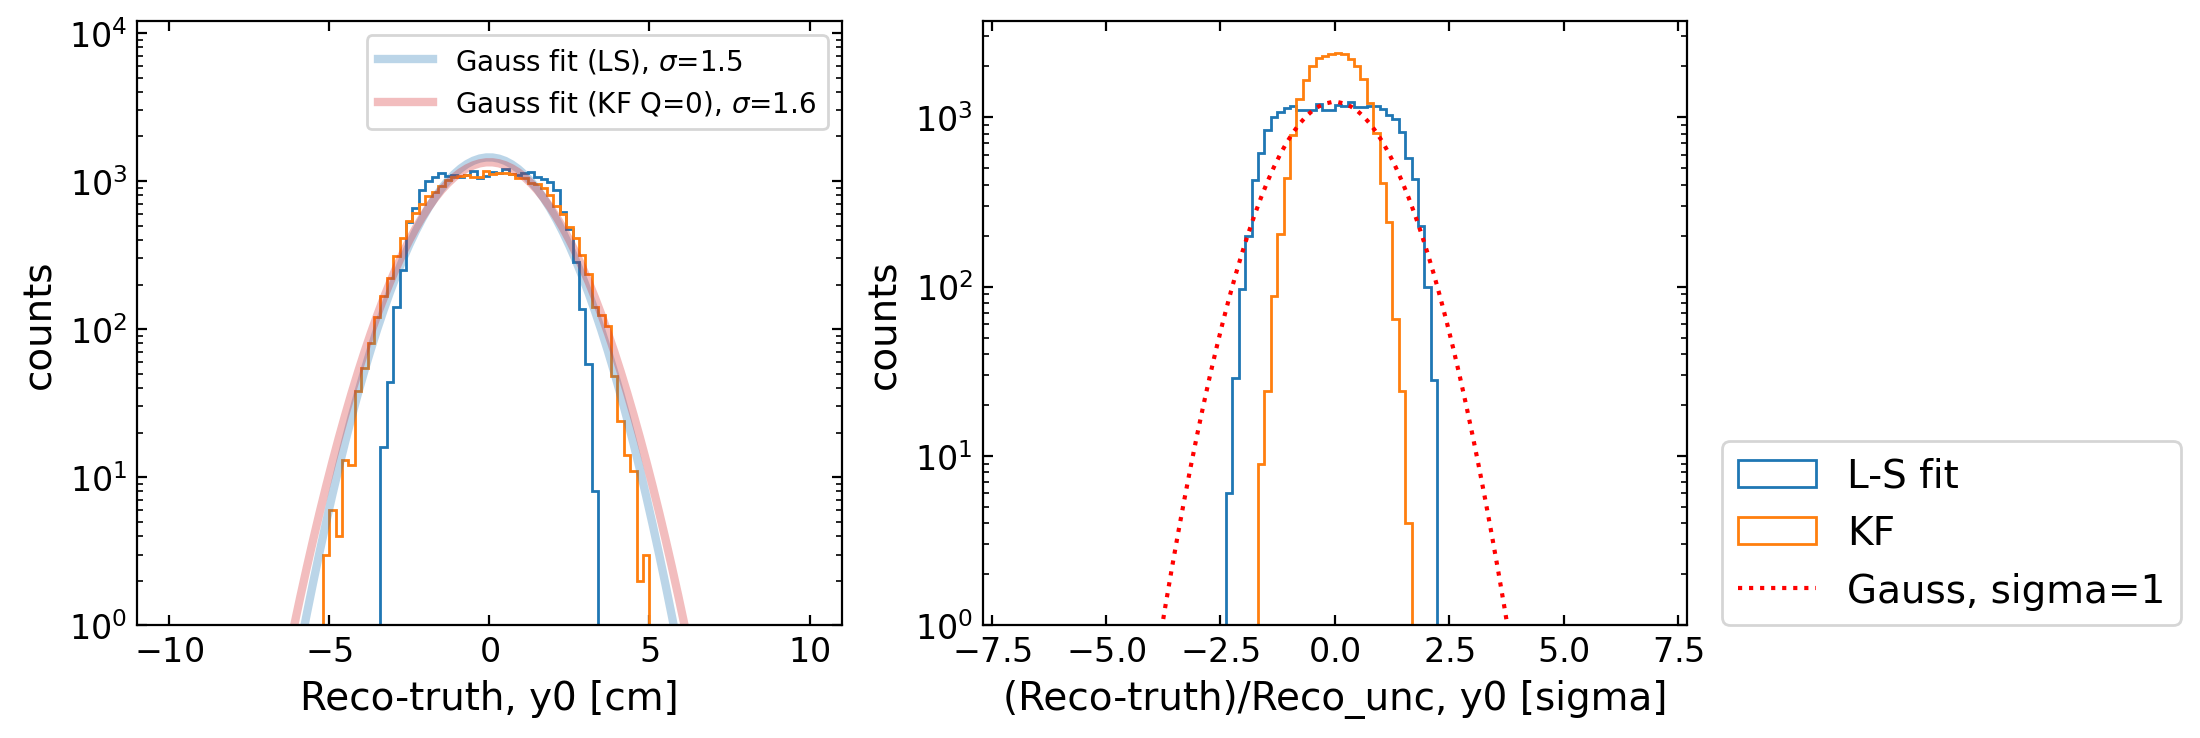

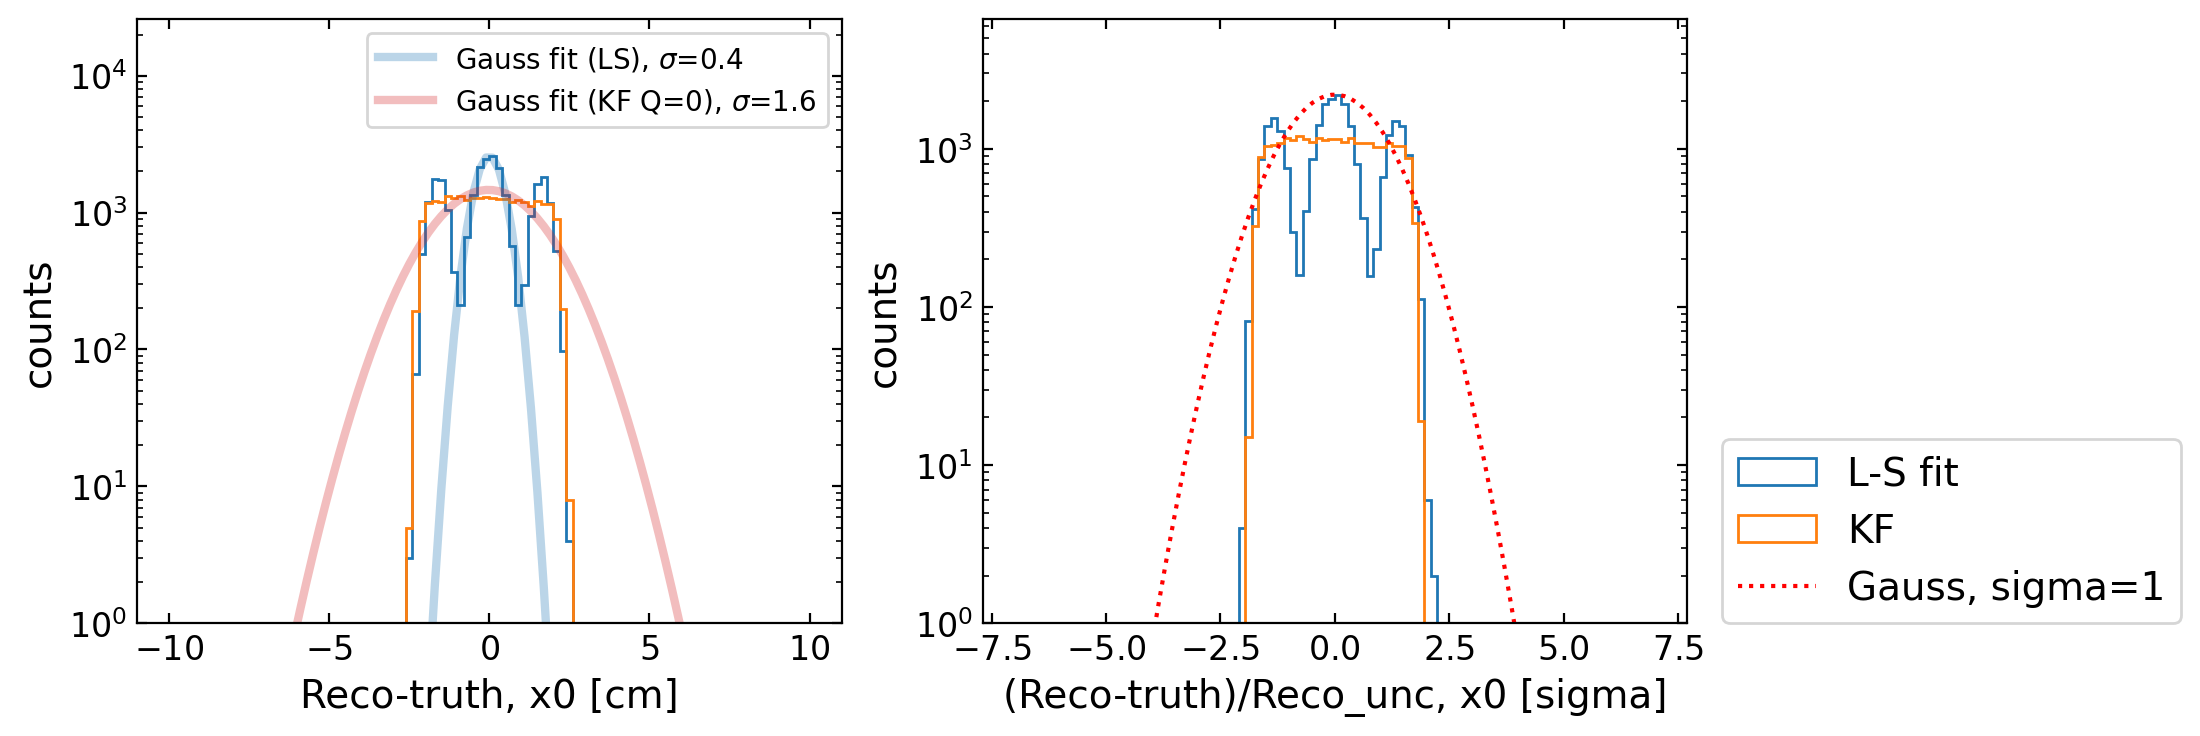

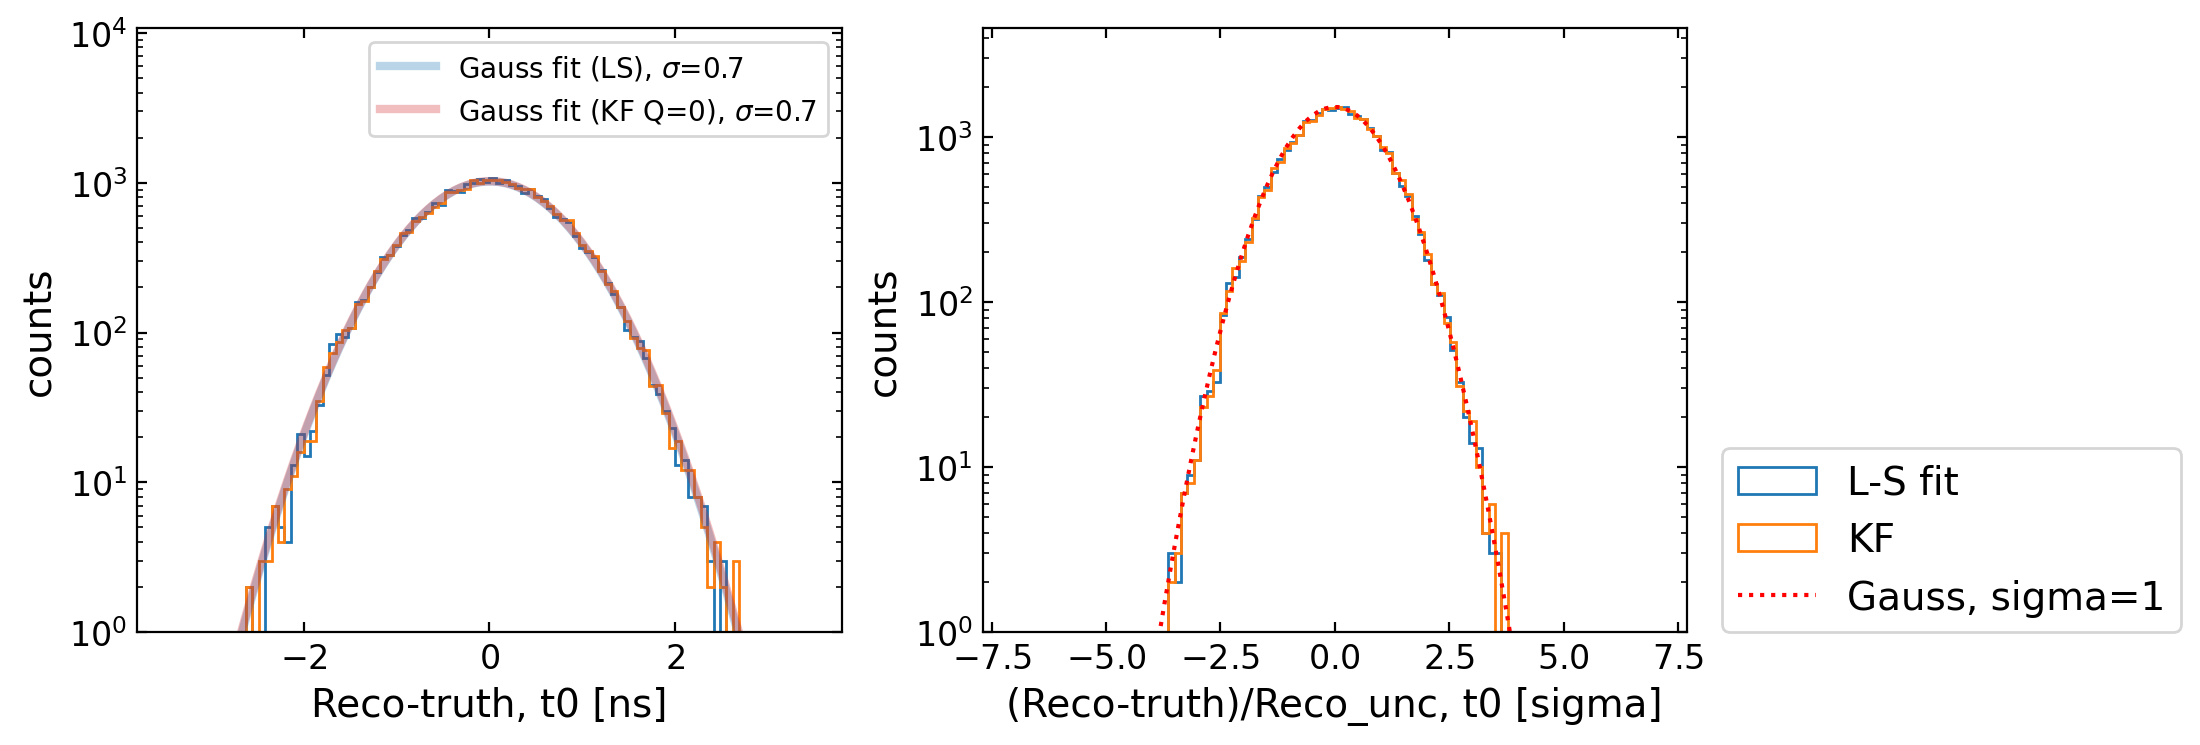

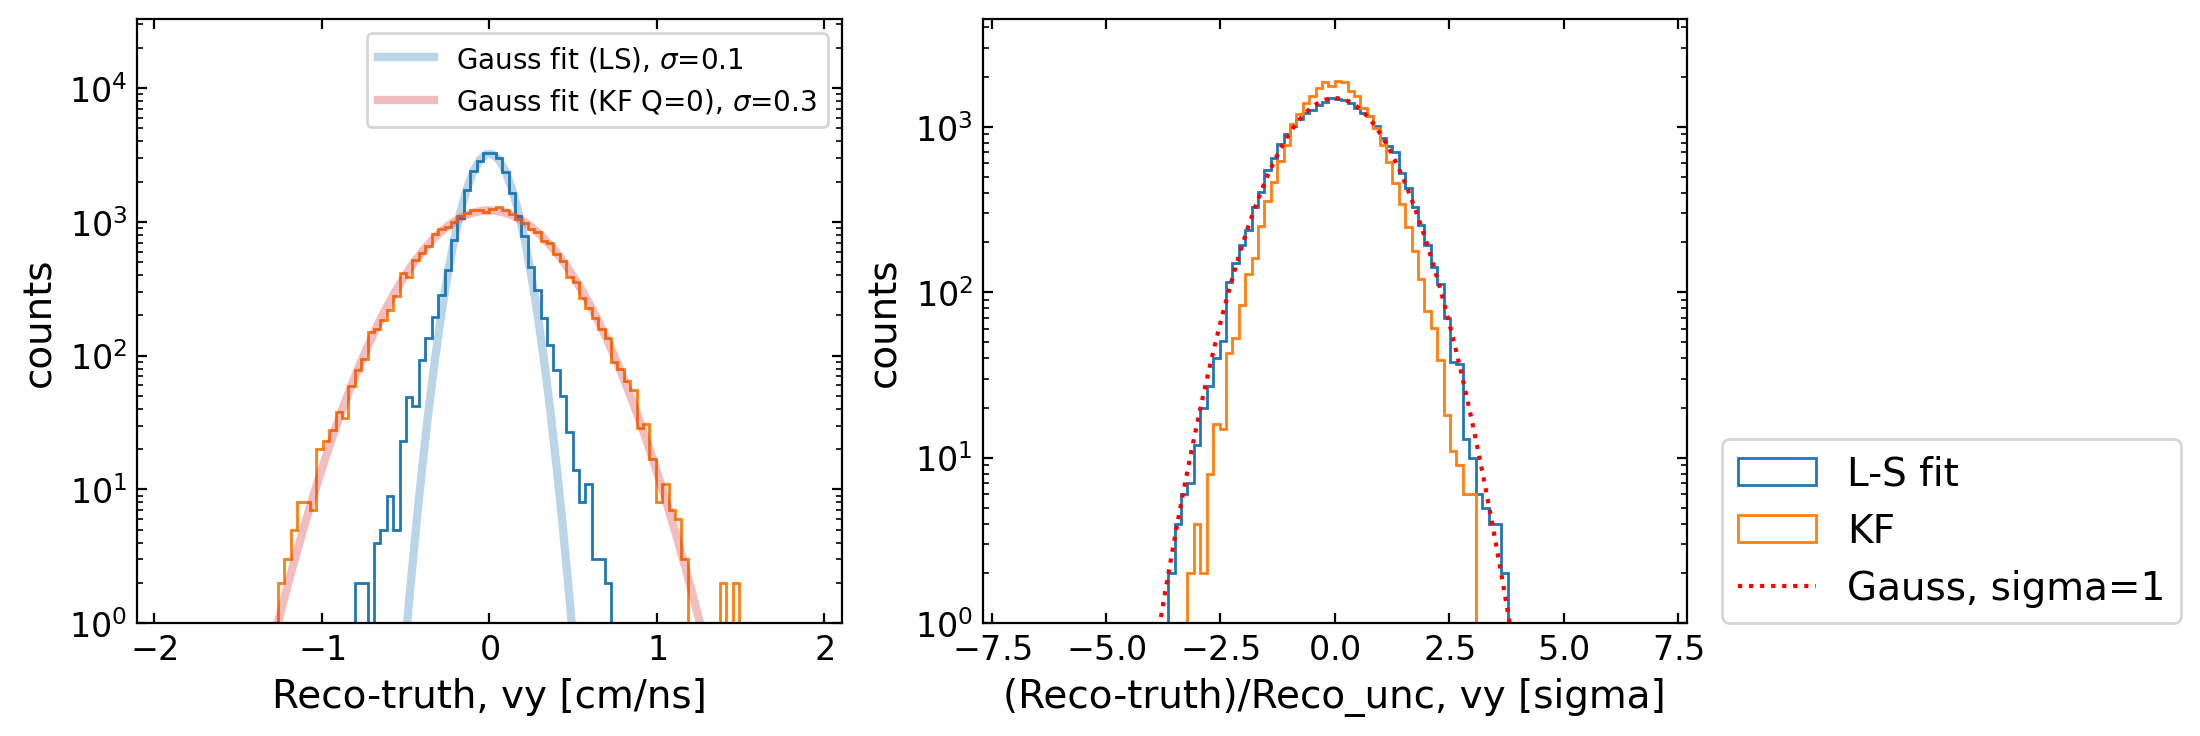

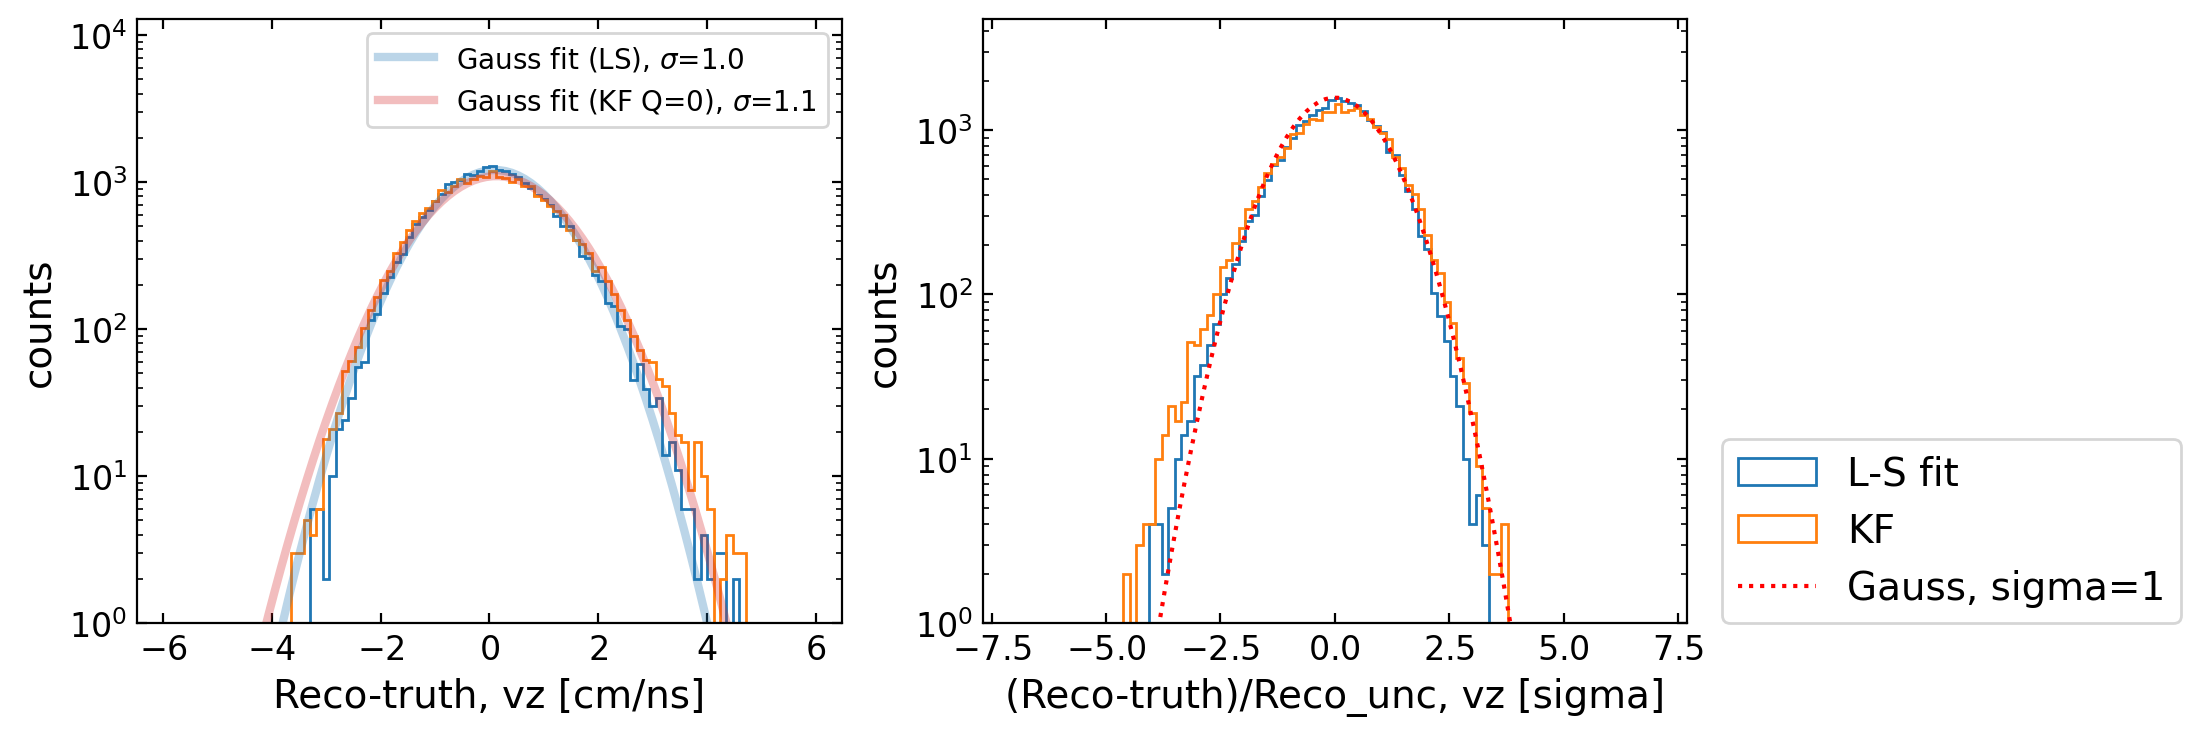

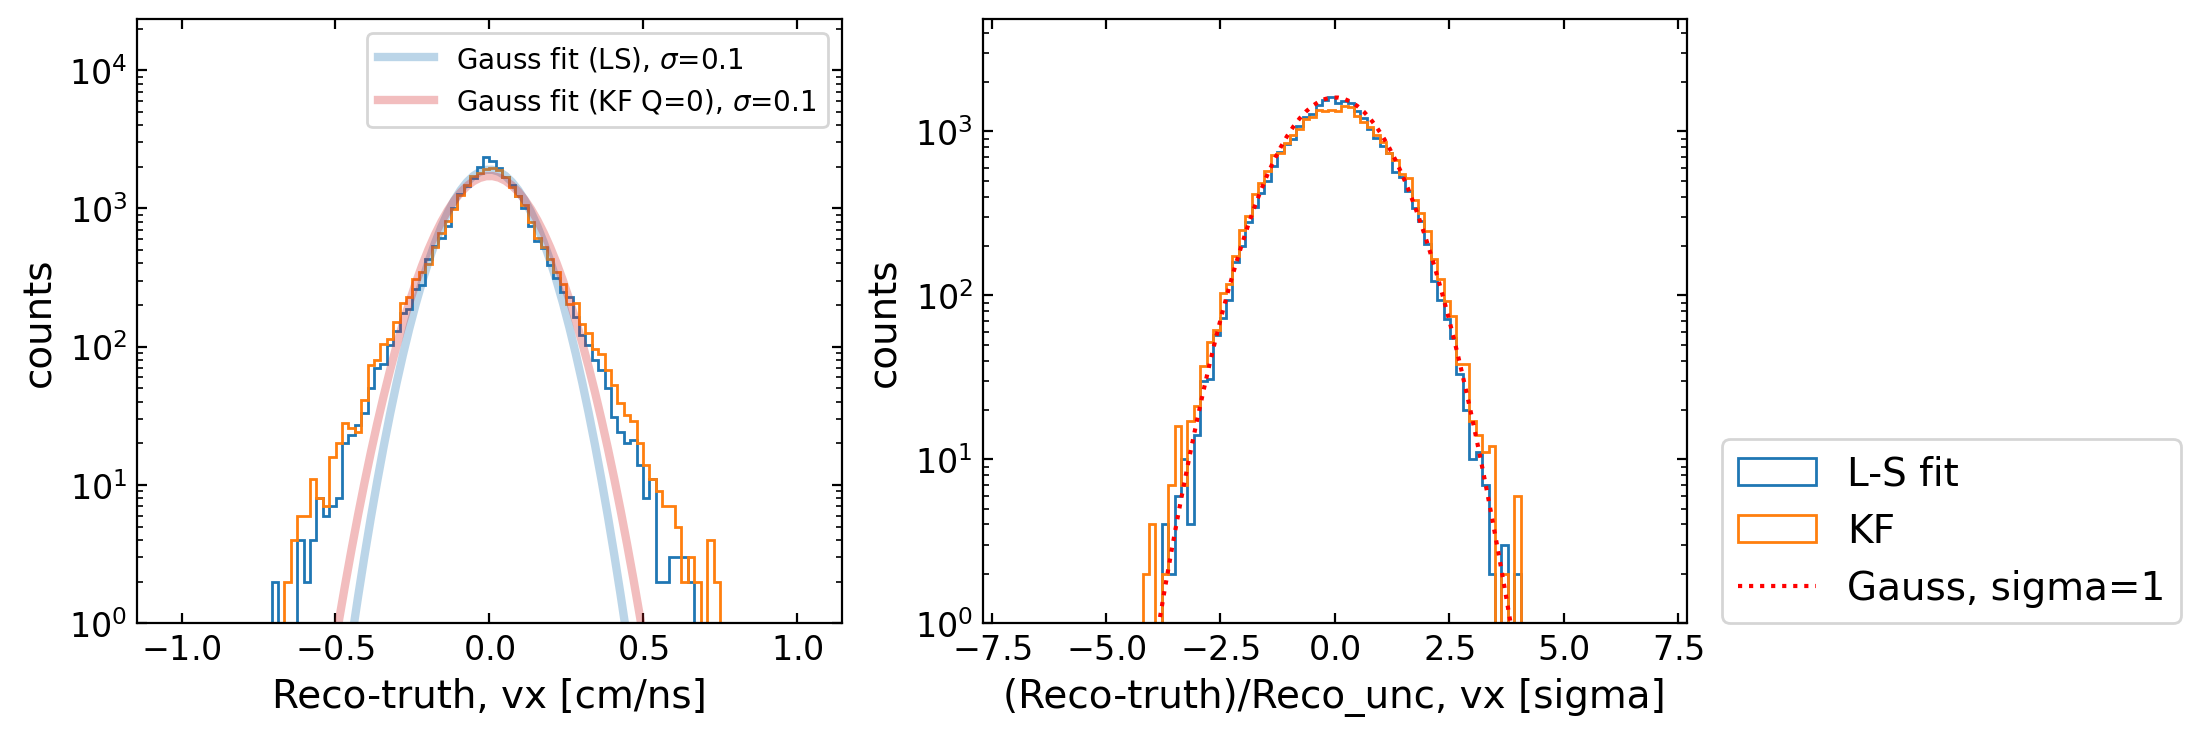

 FCN=5324.81 FROM MIGRAD    STATUS=CONVERGED      79 CALLS          80 TOTAL
                     EDM=8.97618e-09    STRATEGY= 1  ERROR MATRIX UNCERTAINTY   2.3 per cent
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.47051e+03   1.07298e+01   1.04600e-01  -8.15040e-07
   2  Mean         9.81475e-04   8.07402e-03  -1.98212e-05   1.32505e-02
   3  Sigma        1.16869e+00   3.11408e-03   1.81588e-06  -1.80422e-01
 FCN=2695.9 FROM MIGRAD    STATUS=CONVERGED      58 CALLS          59 TOTAL
                     EDM=1.44429e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.44612e+03   1.06460e+01   2.21045e-01   4.62795e-06
   2  Mean        -7.15636e-03   9.27879e-03   2.35224e-04  -1.62918e-03
   3  Sigma        1.

In [33]:
par_names=['y0', 'z0', 'x0', 't0', 'vy', 'vz', 'vx'] # Use real world direction
par_unit= ["[cm]",'[cm]',"[cm]", "[ns]","[cm/ns]","[cm/ns]","[cm/ns]"]
# ranges=[(-20,20),(-20,20),(-20,20),(-20,20),(-30,30),(-30,30),(-30,30)]

for ipar in range(7):
    if ipar==1:
        continue
    #_range=ranges[ipar]
    residual_ls=results_fit["par_fit"][:,ipar]-results_fit["par_truth"][:,ipar]
    residual_km=results_fit["par_km"][:,ipar]-results_fit["par_truth"][:,ipar]
    _range=(np.percentile(residual_km,1)*2,np.percentile(residual_km,99)*2)
    _range=(-max(np.abs(_range)),max(np.abs(_range)))

    if ipar<=2:
        _range=[-10,10]

    def pull(x_measure, x_truth, x_unc):
        return (x_measure-x_truth)/x_unc
    pull_ls=pull(residual_ls,0,results_fit["par_fit_error"][:,ipar])
    pull_km=pull(residual_km,0,np.sqrt(results_fit["par_km_error"][:,ipar]))

    fig,axs=plt.subplots(1,2,figsize=(10,4))
    plt.sca(axs[0])
    n1,ibins,_=plt.hist(residual_ls[mask_7hits],histtype="step",bins=100,color="C0",range=_range);#bins=np.linspace(360,500,100));
    n2,ibins,_=plt.hist(residual_km[mask_7hits],histtype="step",bins=100,color="C1",range=_range);#bins=np.linspace(360,500,100));
#     plt.hist(residual_km[mask_7hits&mask_noshare],bins=100,color="C2",alpha=0.2,range=_range,label="L-S fit + no energy share");#bins=np.linspace(360,500,100));
    # plt.hist(residual_ls[mask_7hits],bins=100,alpha=0.2,range=_range);#bins=np.linspace(360,500,100));
    # plt.hist(residual_km[mask_7hits],color="C1",bins=100,alpha=0.2,range=_range);#bins=np.linspace(360,500,100));
#     plt.hist(residual_ls[mask_7hits&mask_noshare],histtype="step",bins=100,range=_range,label="L-S fit + no energy share");#bins=np.linspace(360,500,100));
 
    plt.xlabel(f"Reco-truth, {par_names[ipar]} {par_unit[ipar]}")
    plt.ylabel("counts")
    plt.yscale("log")
    
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    yerr=np.sqrt(n1)
    yerr[yerr==0]=1    
    popt,pcov = rt.fit_tg(bincenters,n1,yerr=yerr,function="gaus")
    mask = np.abs(bincenters-popt[1])<3*popt[2]
    # Apply a 3 sigma cut and fit again
    popt,pcov = rt.fit_tg(bincenters[mask],n1[mask],yerr=np.sqrt(n)[mask],function="gaus")
    plt.plot(bincenters,util.Utils.Gauss(bincenters, *popt),color="C0",alpha=0.3,linewidth=3,label=r"Gauss fit (LS), $\sigma$="+f"{popt[-1]:.1f}")

    yerr=np.sqrt(n2)
    yerr[yerr==0]=1       
    popt,pcov = rt.fit_tg(bincenters,n2,yerr=yerr,function="gaus")
    mask = np.abs(bincenters-popt[1])<3*popt[2]
    # Apply a 3 sigma cut and fit again
    popt,pcov = rt.fit_tg(bincenters[mask],n2[mask],yerr=np.sqrt(n)[mask],function="gaus")
    plt.plot(bincenters,util.Utils.Gauss(bincenters, *popt),color="C3",alpha=0.3,linewidth=3,label=r"Gauss fit (KF Q=0), $\sigma$="+f"{popt[-1]:.1f}")    
    
    
    plt.legend(fontsize=10)
    plt.ylim(1,max(n1)*10)   

    
    
    
    plt.sca(axs[1])
    _range_pull=[-7,7]
    n,ibins,_=plt.hist(pull_ls[mask_7hits],histtype="step",bins=100,range=_range_pull,label="L-S fit");#bins=np.linspace(360,500,100));
    # n,ibins,_=plt.hist(pull_ls[mask_7hits],alpha=0.2,color="C0", bins=100,range=_range_pull,label="L-S fit + 7 hits");#bins=np.linspace(360,500,100));

    plt.hist(pull_km[mask_7hits],histtype="step",bins=100,range=_range_pull,label="KF");#bins=np.linspace(360,500,100));
    # plt.hist(pull_km[mask_7hits],alpha=0.2,color="C1", bins=100,range=_range_pull,label="KF + 7 hits");#bins=np.linspace(360,500,100));
    

    
    bincenters=0.5*(ibins[1:]+ibins[:-1])
    y = util.Utils.Gauss(bincenters, max(n),0,1)
    plt.plot(bincenters,y,color="r",label="Gauss, sigma=1",linestyle=":")
    plt.ylim(1,max(n)*3)
    
    
    plt.legend(loc=(1.05,0))
    plt.xlabel(f"(Reco-truth)/Reco_unc, {par_names[ipar]} [sigma]")
    plt.ylabel("counts")
    plt.yscale("log")  
    
    savefig(f"LS_v_KF_{ipar}")

    plt.show()
        


In [34]:
results_noscatter={}
get_km(f"{file_prefix}/stat_noscatter.root", results_noscatter, tree_name)
results_original={}
get_km(f"{file_prefix}/stat_original.root", results_original, tree_name)

100%|██████████| 40000/40000 [00:21<00:00, 1887.00it/s]


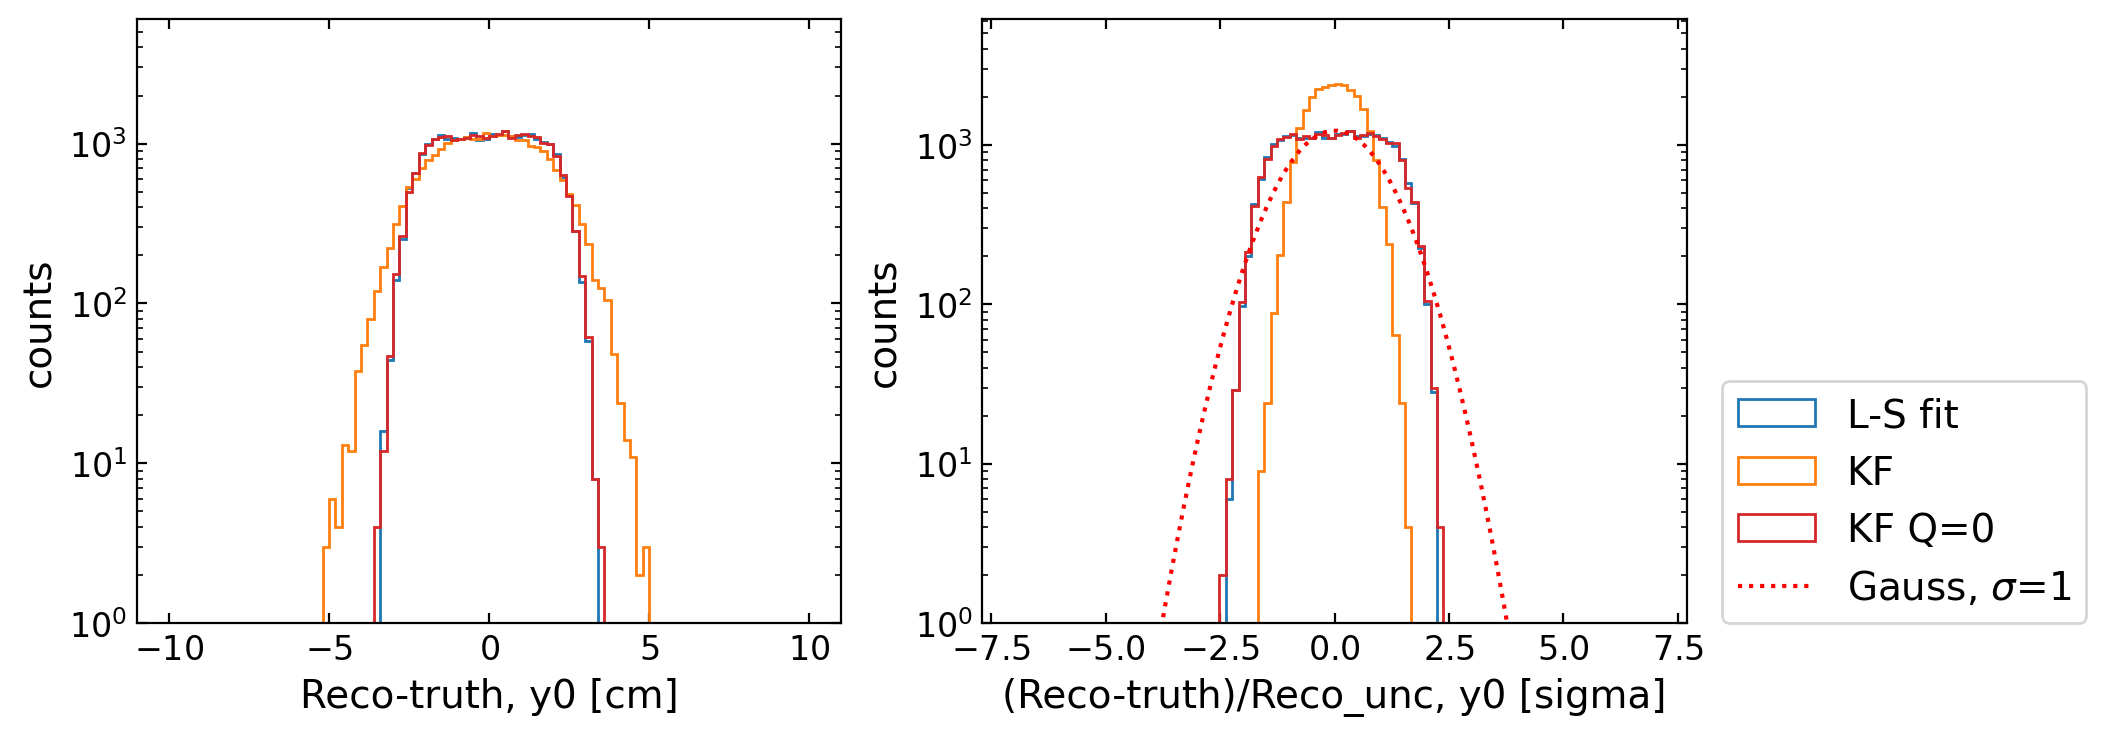

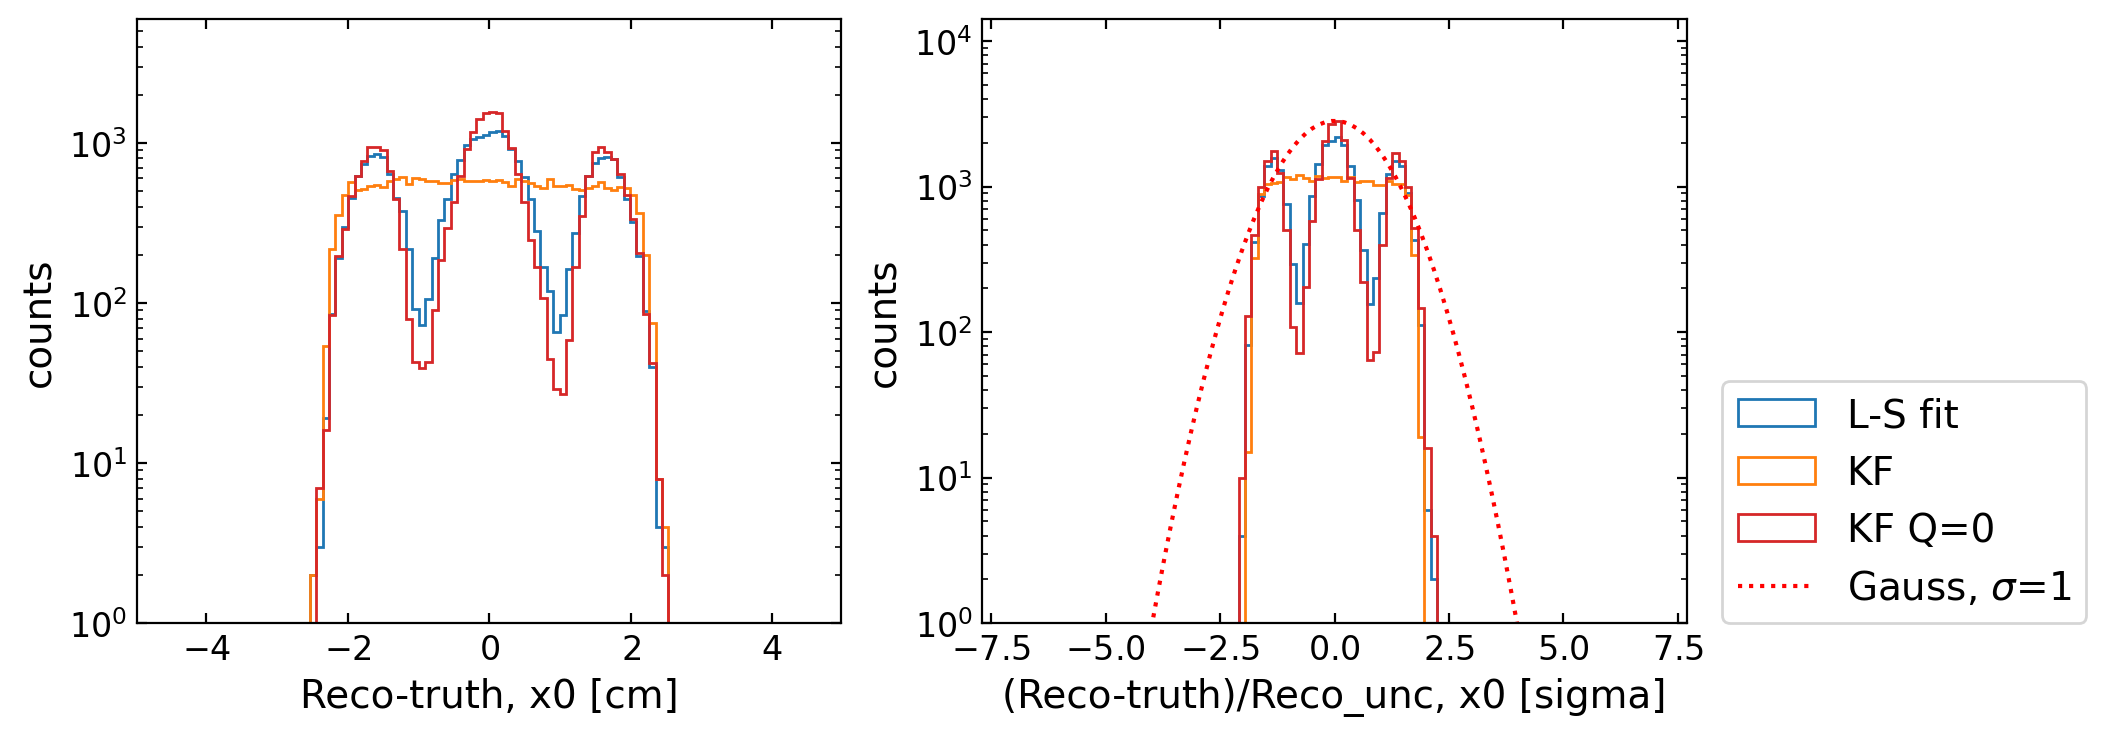

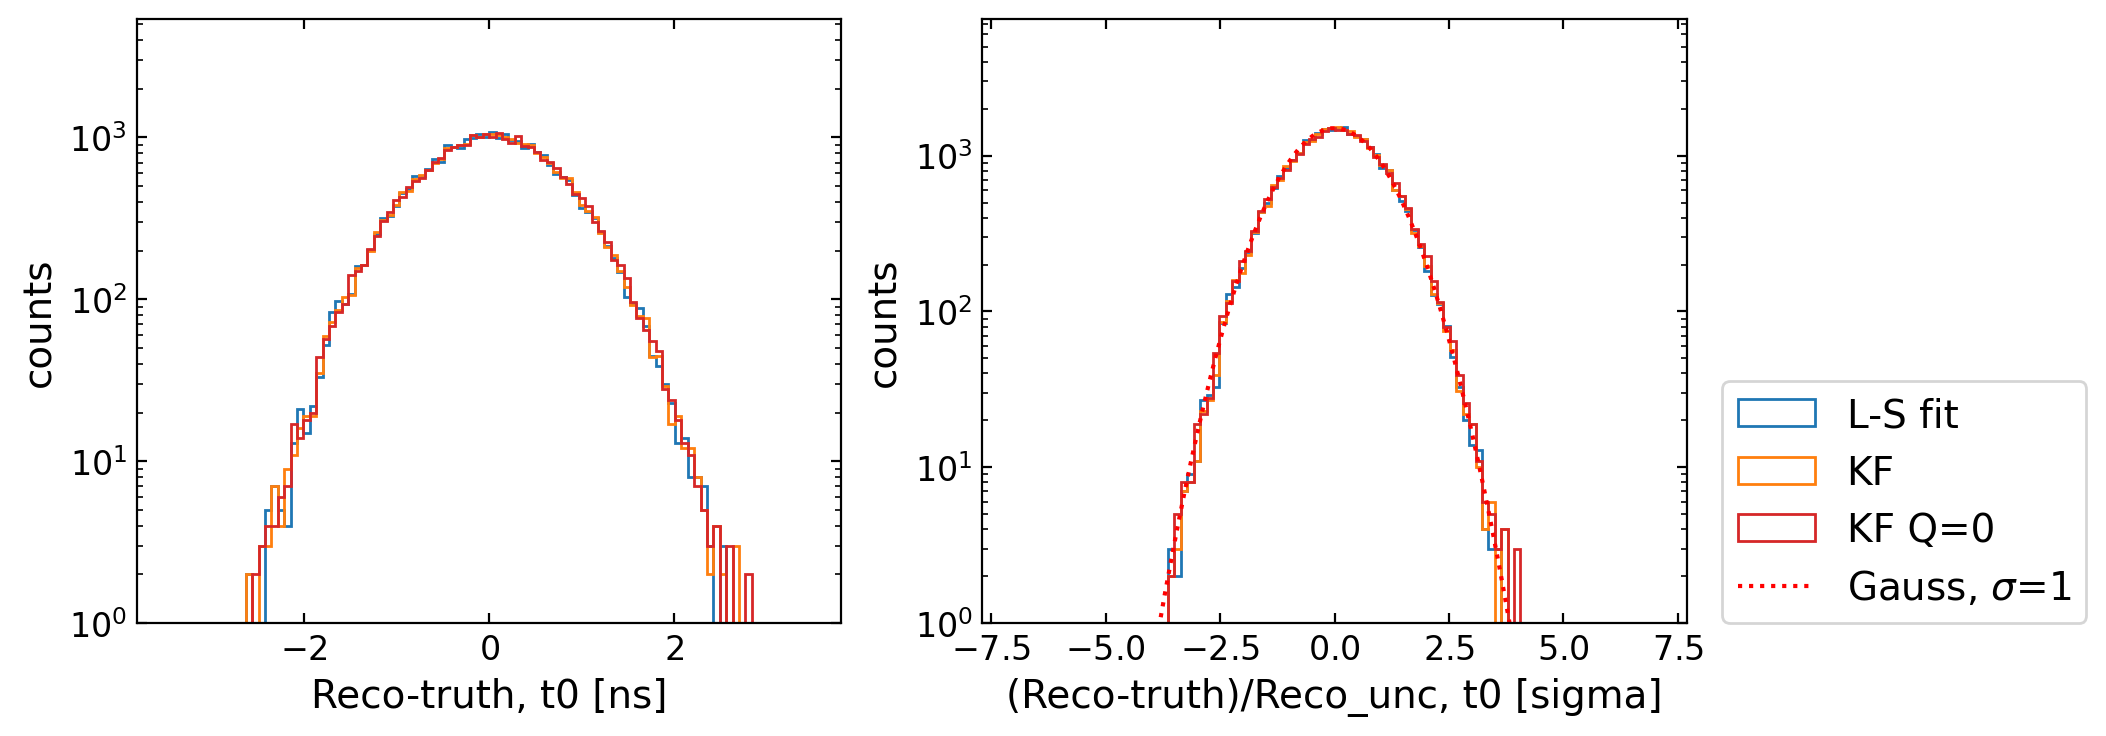

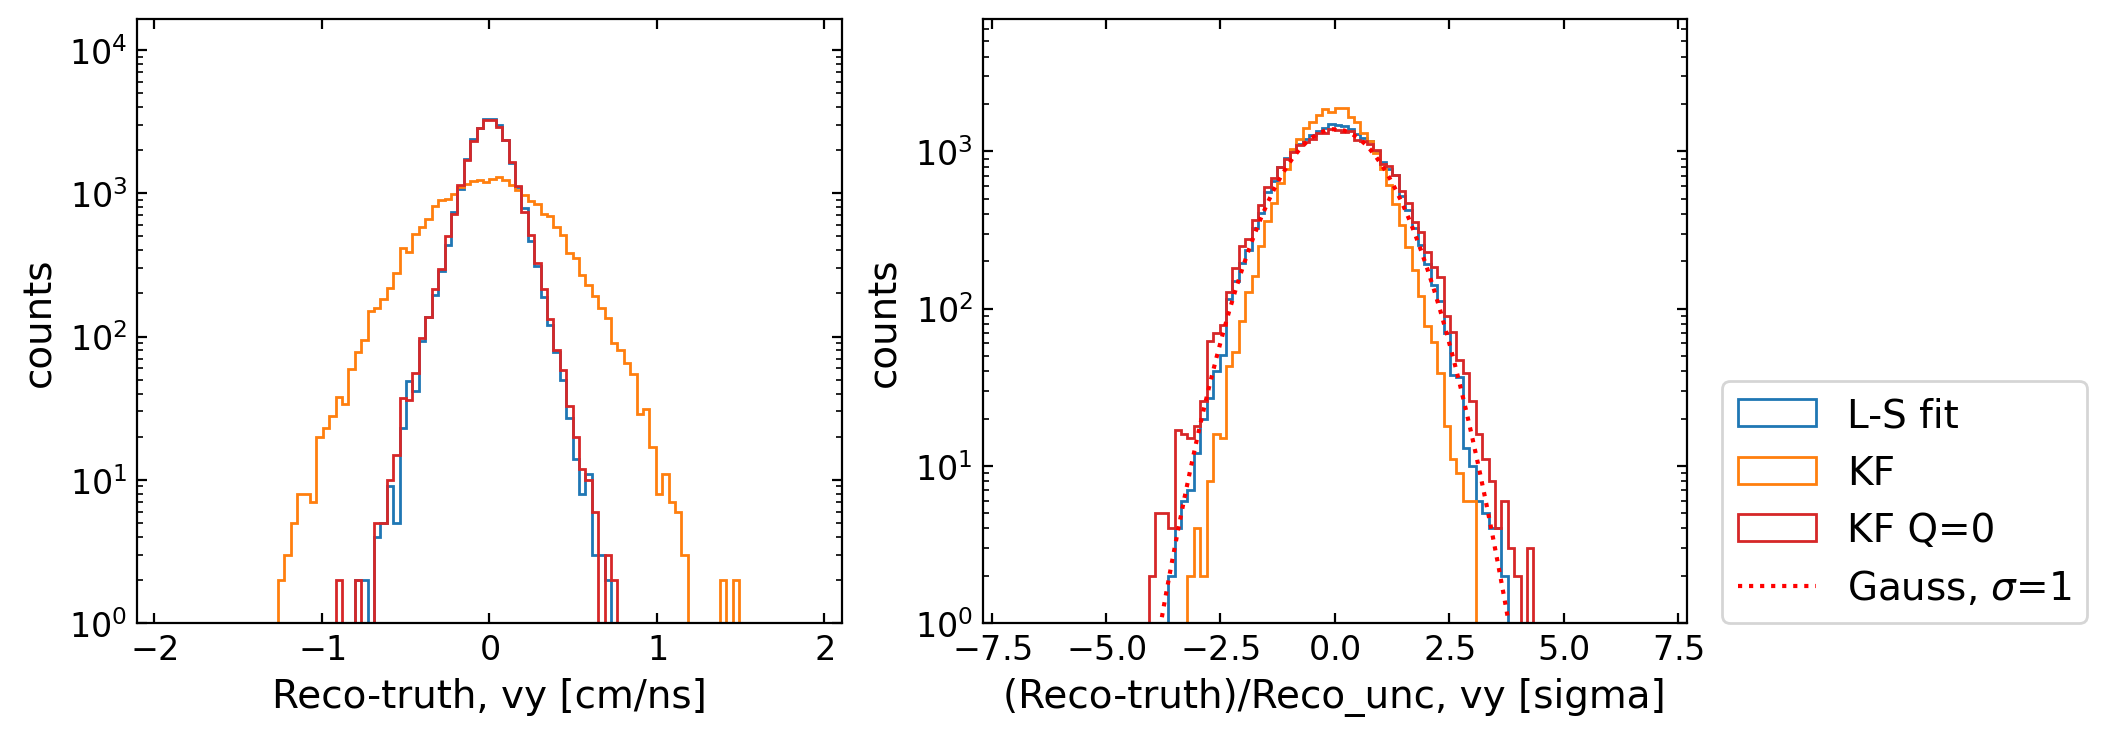

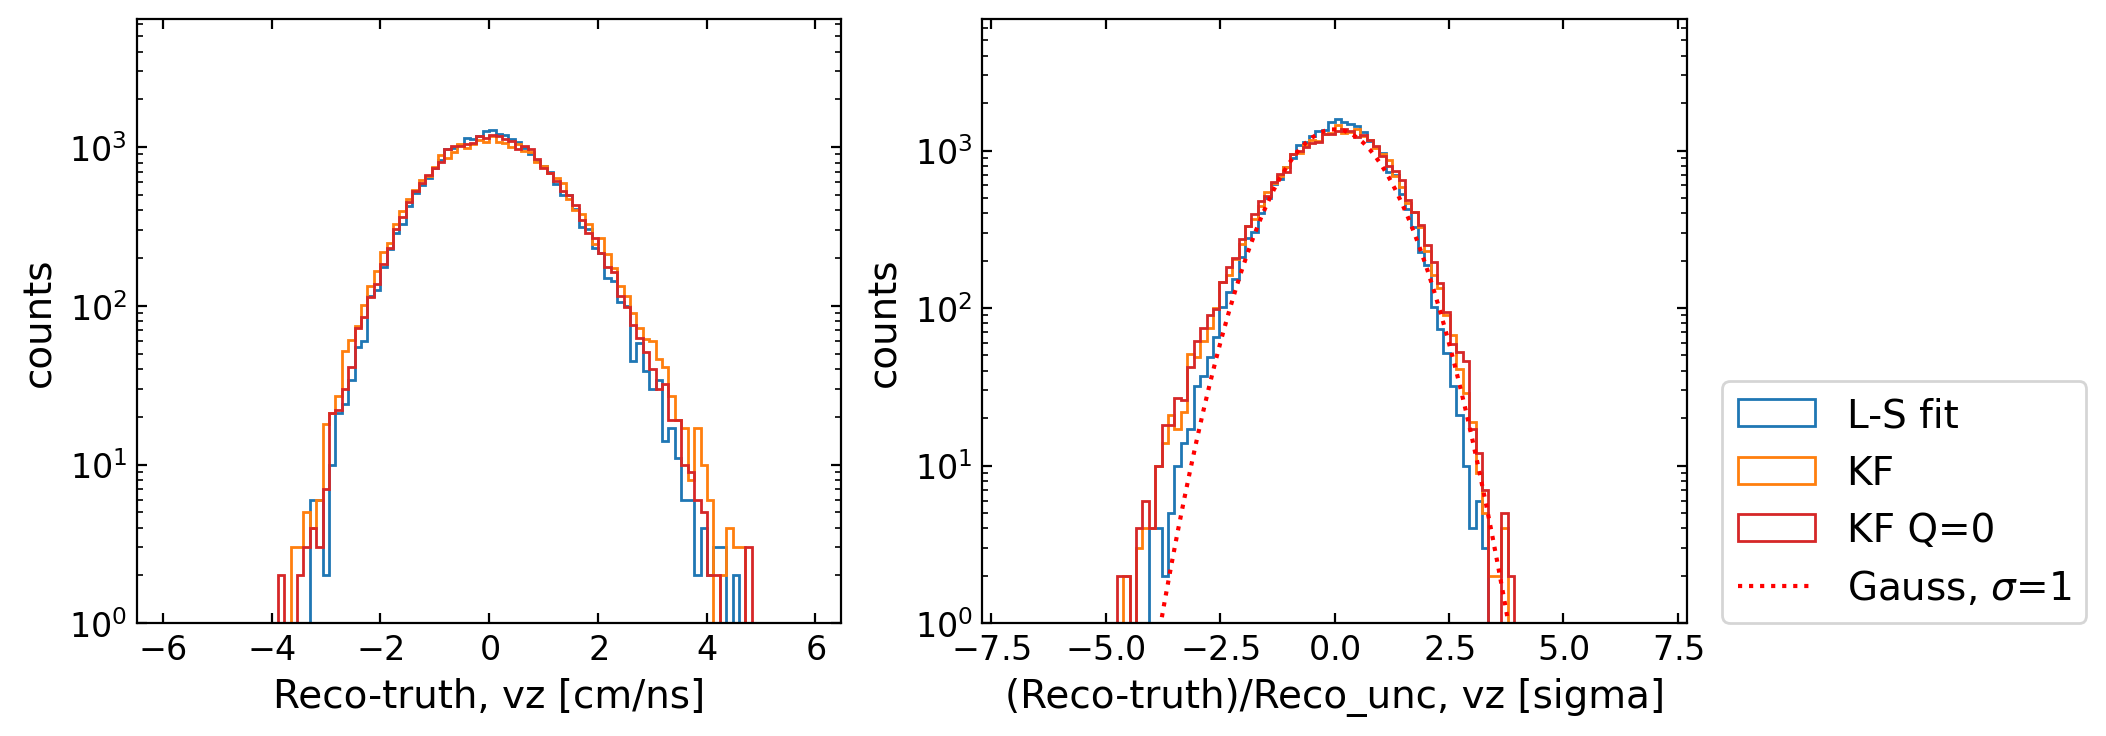

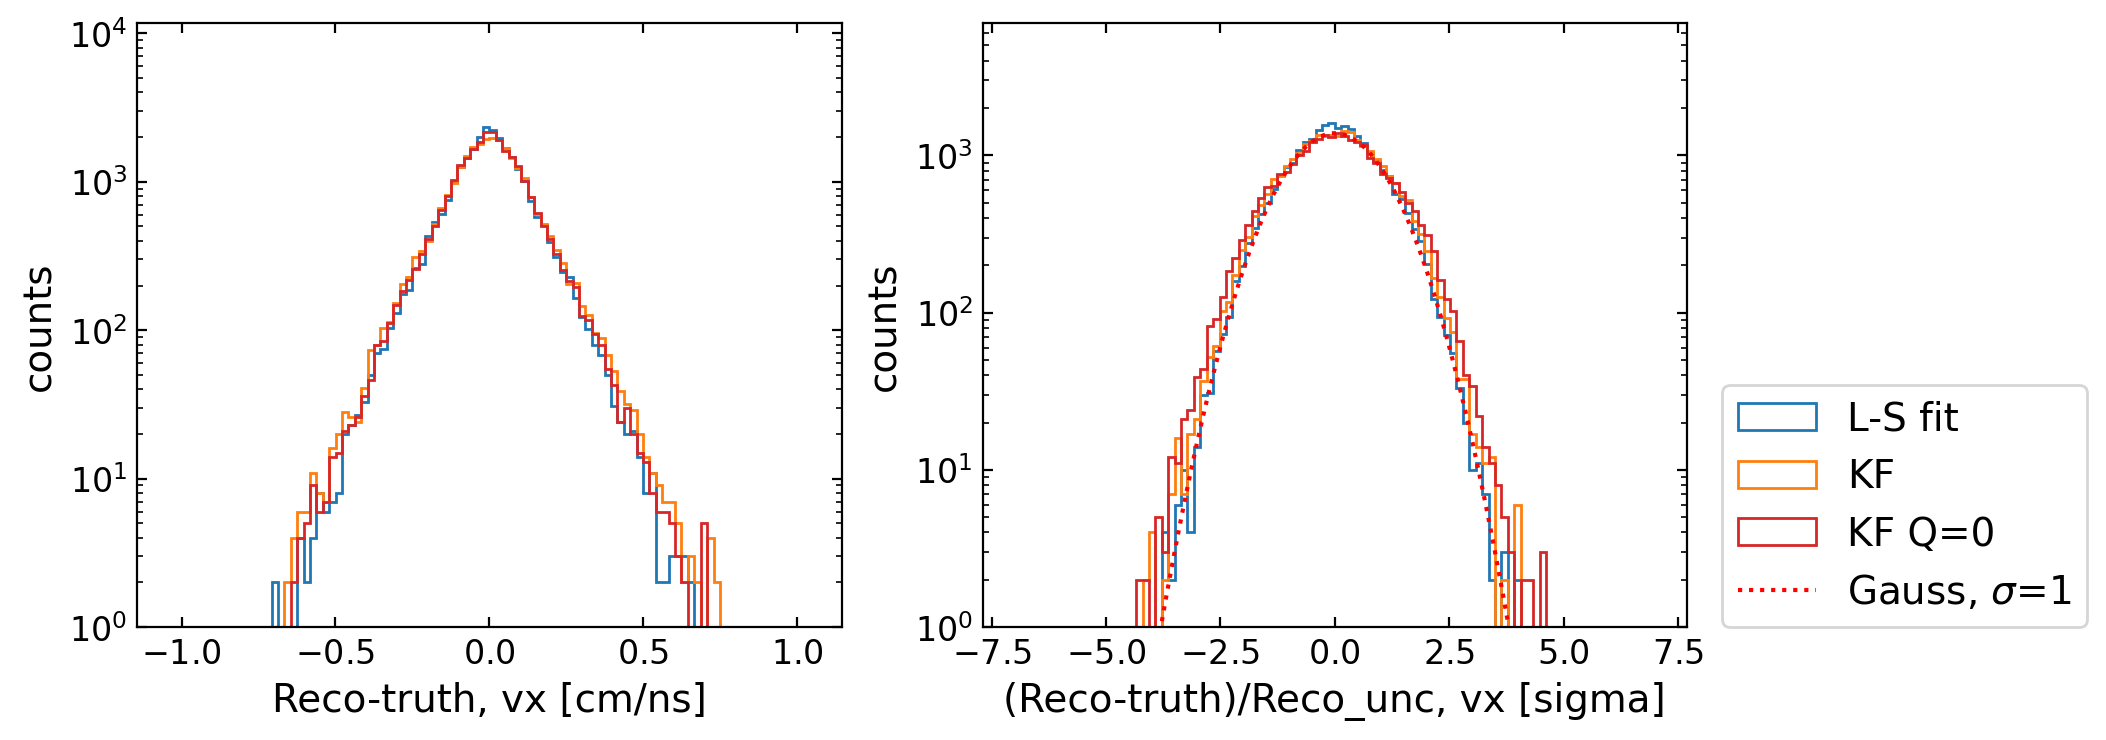

In [37]:

for ipar in range(7):
    if ipar==1:
        continue
    #_range=ranges[ipar]
    residual_ls=results_fit["par_fit"][:,ipar]-results_fit["par_truth"][:,ipar]
    residual_km=results_fit["par_km"][:,ipar]-results_fit["par_truth"][:,ipar]
    residual_km0=results_original["par_km"][:,ipar]-results_original["par_km_truth"][:,ipar]
    residual_km1=results_noscatter["par_km"][:,ipar]-results_noscatter["par_km_truth"][:,ipar]
    mask_7hits0 = results_original["par_km_ndigi"]==7
    mask_7hits1 = results_noscatter["par_km_ndigi"]==7
    _range=(np.percentile(residual_km,1)*2,np.percentile(residual_km,99)*2)
    _range=(-max(np.abs(_range)),max(np.abs(_range)))

    if ipar<2:
        _range=[-10,10]

    def pull(x_measure, x_truth, x_unc):
        return (x_measure-x_truth)/x_unc
    pull_ls=pull(residual_ls,0,results_fit["par_fit_error"][:,ipar])
    pull_km=pull(residual_km,0,np.sqrt(results_fit["par_km_error"][:,ipar]))
    pull_km0=pull(residual_km0,0,np.sqrt(results_original["par_km_error"][:,ipar]))
    pull_km1=pull(residual_km1,0,np.sqrt(results_noscatter["par_km_error"][:,ipar]))

    fig,axs=plt.subplots(1,2,figsize=(10,4))
    plt.sca(axs[0])
    n1,ibins,_=plt.hist(residual_ls[mask_7hits],histtype="step",bins=100,color="C0",range=_range);#bins=np.linspace(360,500,100));
    plt.hist(residual_km[mask_7hits],histtype="step",bins=100,color="C1",range=_range);#bins=np.linspace(360,500,100));
    n2,ibins,_=plt.hist(residual_km1[mask_7hits1],histtype="step",bins=100,color="C3",range=_range);#bins=np.linspace(360,500,100));
    # plt.hist(residual_km0[mask_7hits0],histtype="step",bins=100,color="grey",range=_range);#bins=np.linspace(360,500,100));
 
    plt.xlabel(f"Reco-truth, {par_names[ipar]} {par_unit[ipar]}")
    plt.ylabel("counts")
    plt.yscale("log")
    plt.ylim(1,max(n1)*5)  
    
    

    plt.sca(axs[1])
    _range_pull=[-7,7]
    plt.hist(pull_ls[mask_7hits],histtype="step",bins=100,range=_range_pull,label="L-S fit");#bins=np.linspace(360,500,100));
    plt.hist(pull_km[mask_7hits],histtype="step",bins=100,range=_range_pull,label="KF");#bins=np.linspace(360,500,100));
    n,ibins,_=plt.hist(pull_km1[mask_7hits1],histtype="step",bins=100,range=_range_pull,label="KF Q=0",color="C3");#bins=np.linspace(360,500,100));
    # plt.hist(pull_km0[mask_7hits0],histtype="step",bins=100,range=_range_pull,label="KF original",color="grey");#bins=np.linspace(360,500,100));
    

    bincenters=0.5*(ibins[1:]+ibins[:-1])
    y = util.Utils.Gauss(bincenters, max(n),0,1)
    plt.plot(bincenters,y,color="r",label=r"Gauss, $\sigma$=1",linestyle=":")
    plt.ylim(1, max(n)*5)
    
    
    plt.legend(loc=(1.05,0))
    plt.xlabel(f"(Reco-truth)/Reco_unc, {par_names[ipar]} [sigma]")
    plt.ylabel("counts")
    plt.yscale("log")    
    
    savefig(f"LS_v_KF_Q=0_{ipar}")

    plt.show()
        


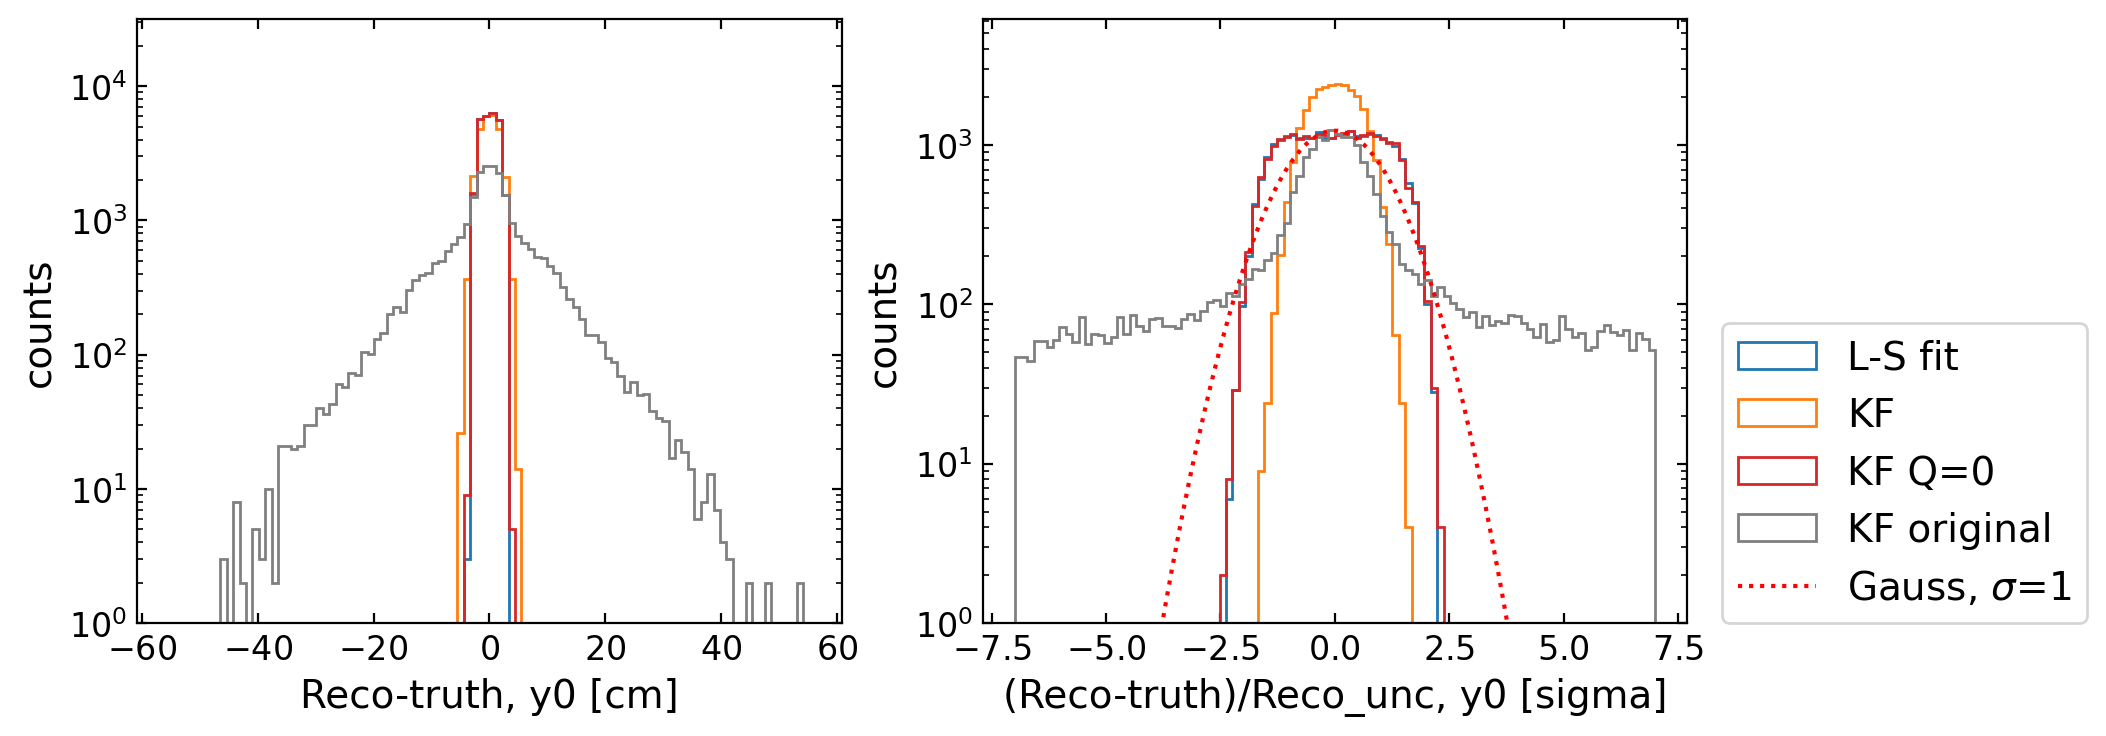

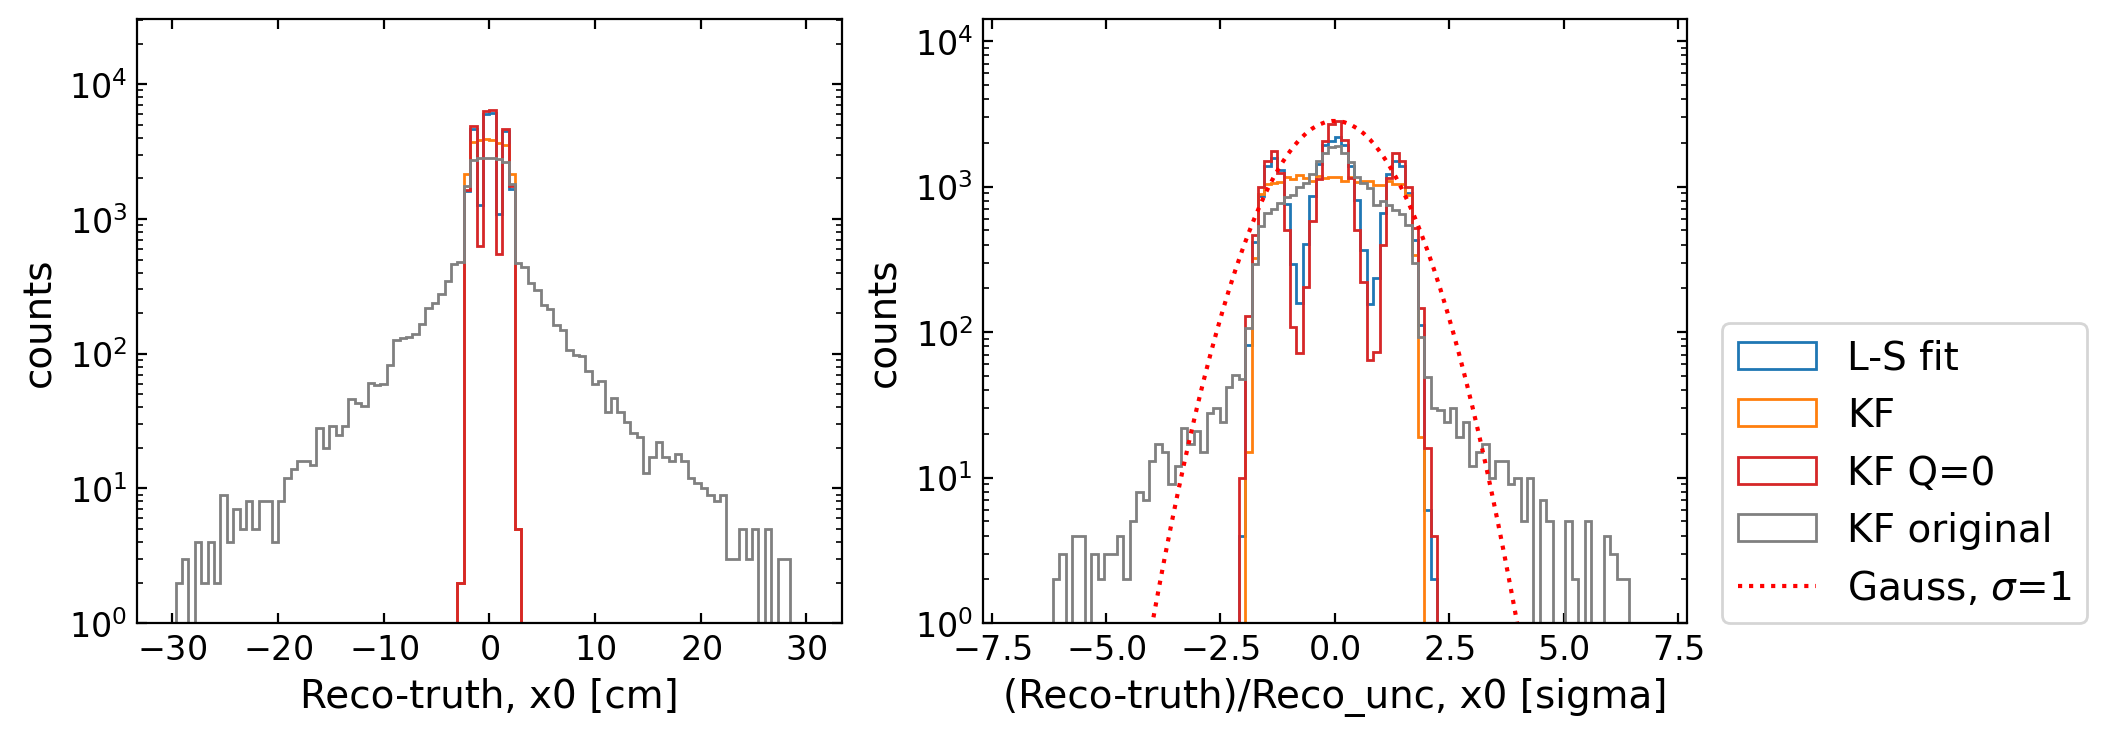

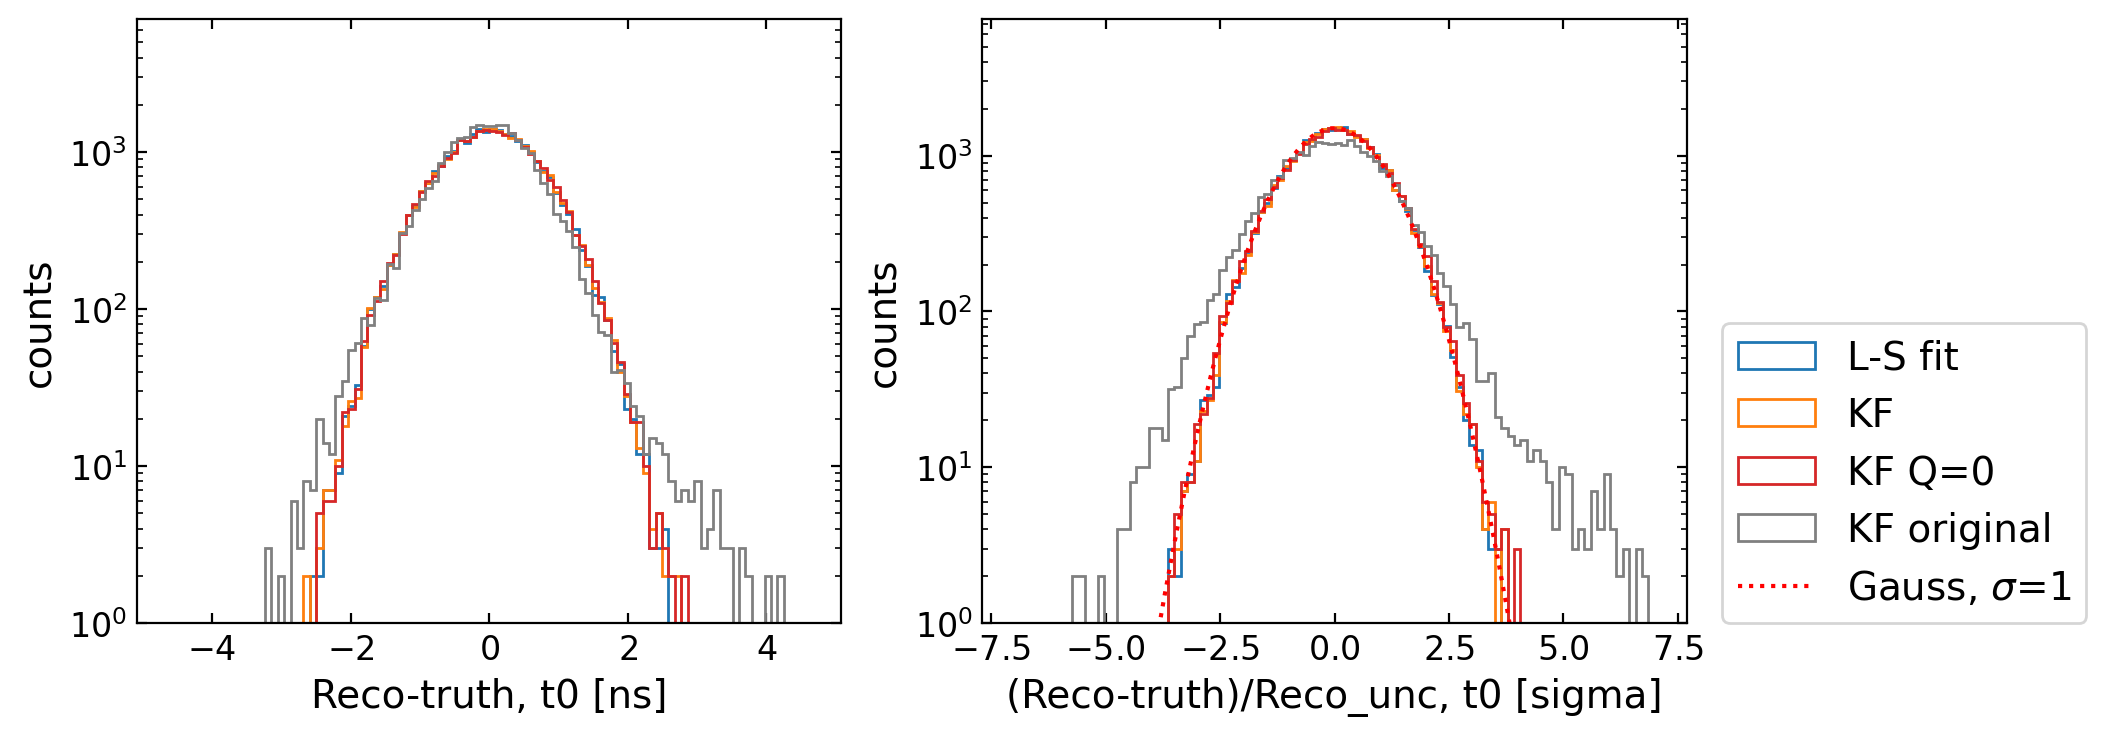

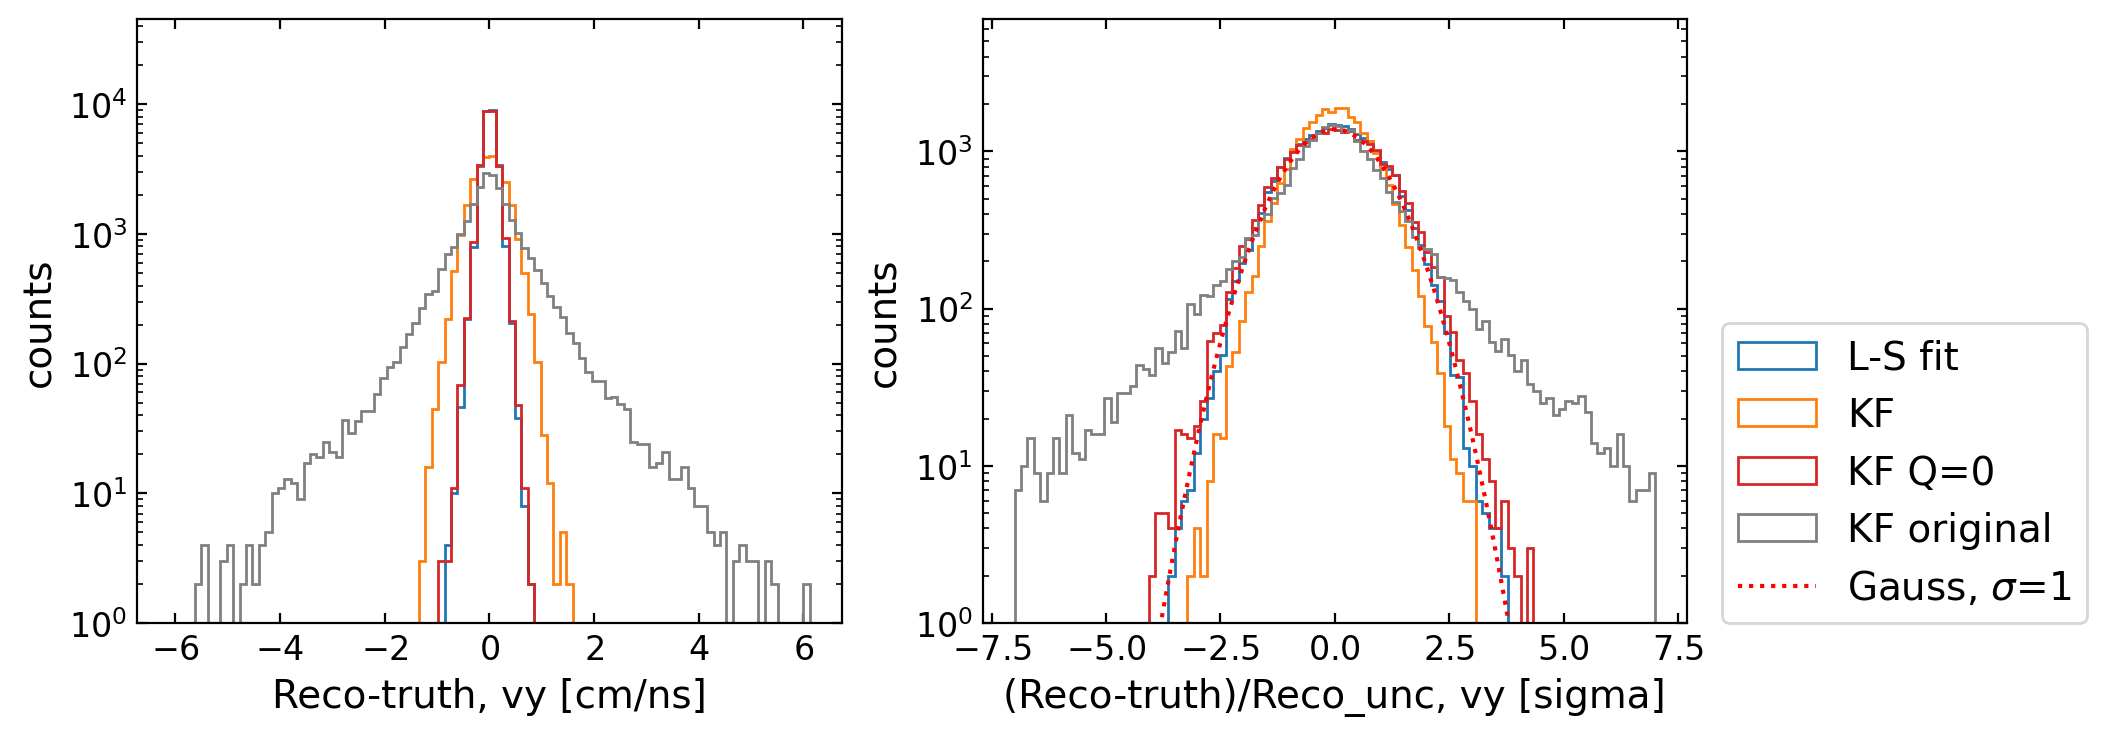

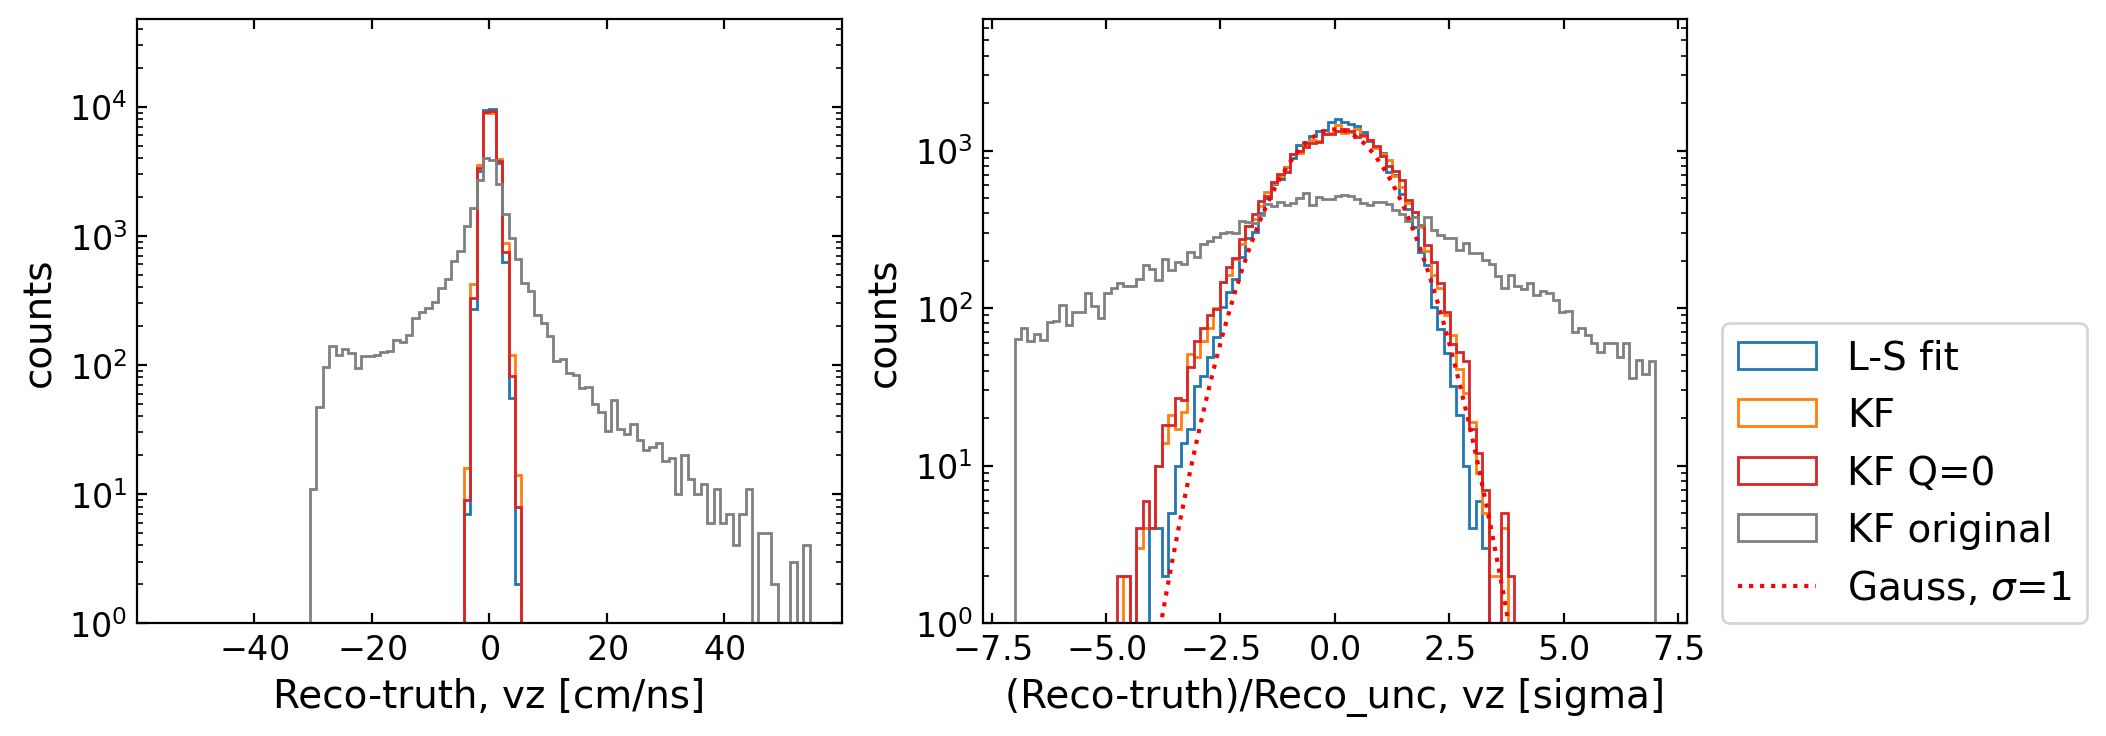

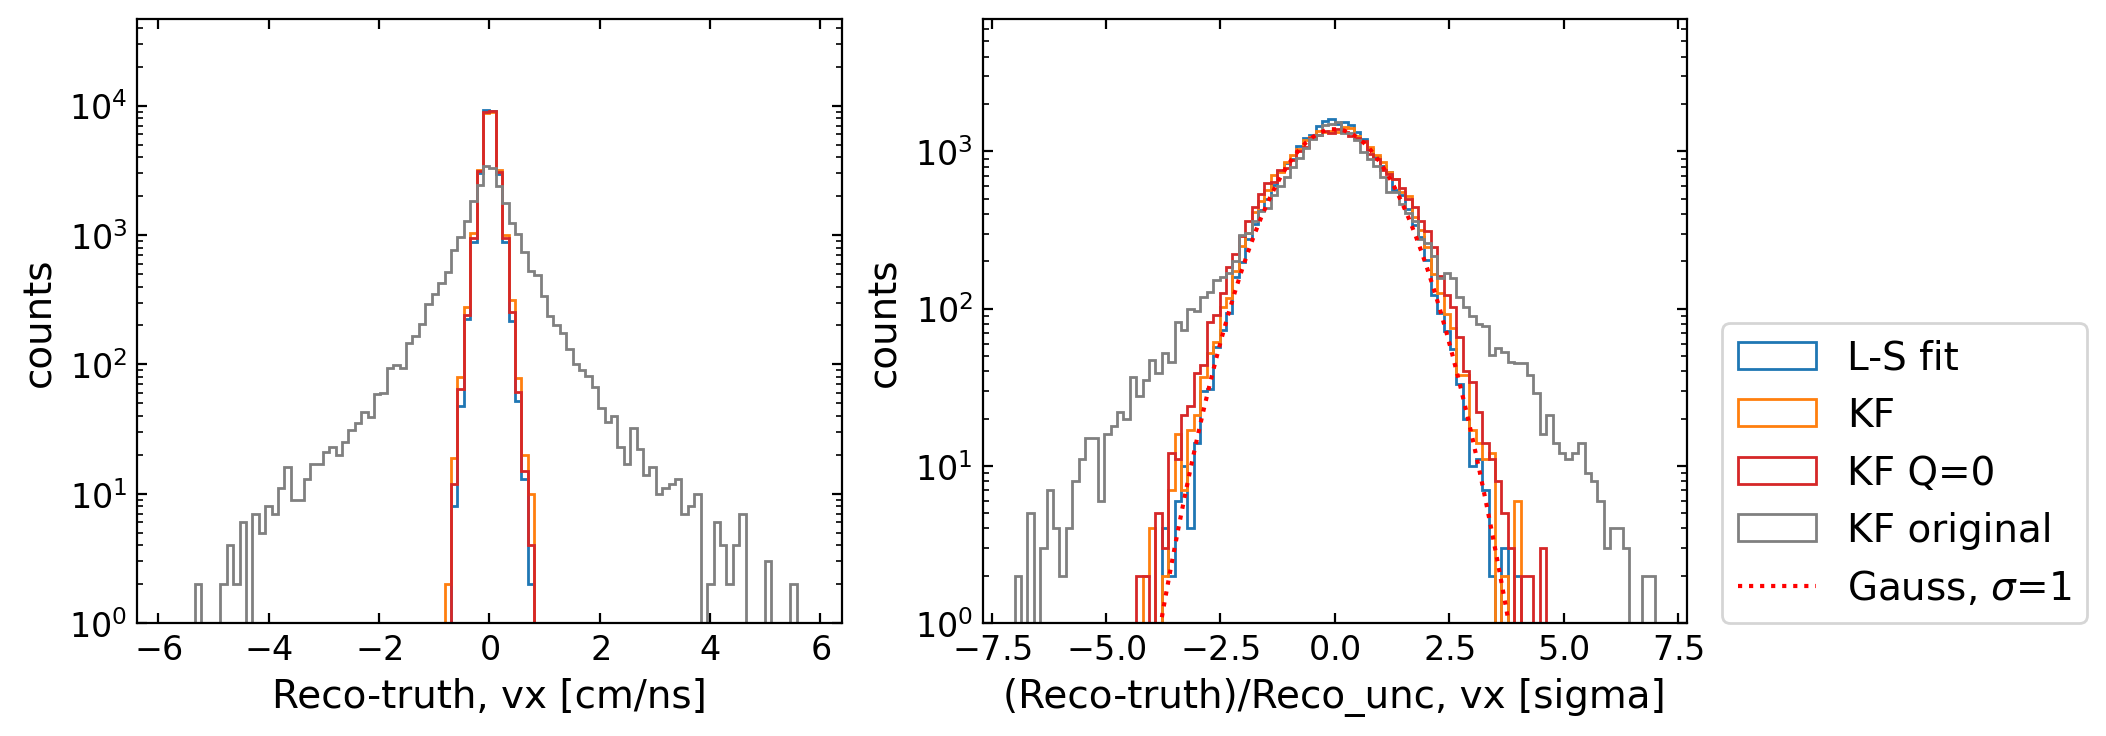

In [38]:

for ipar in range(7):
    if ipar==1:
        continue
    #_range=ranges[ipar]
    residual_ls=results_fit["par_fit"][:,ipar]-results_fit["par_truth"][:,ipar]
    residual_km=results_fit["par_km"][:,ipar]-results_fit["par_truth"][:,ipar]
    residual_km0=results_original["par_km"][:,ipar]-results_original["par_km_truth"][:,ipar]
    residual_km1=results_noscatter["par_km"][:,ipar]-results_noscatter["par_km_truth"][:,ipar]
    mask_7hits0 = results_original["par_km_ndigi"]==7
    mask_7hits1 = results_noscatter["par_km_ndigi"]==7
    _range=(np.percentile(residual_km0,1)*2,np.percentile(residual_km0,99)*2)
    _range=(-max(np.abs(_range)),max(np.abs(_range)))

    # if ipar<2:
    #     _range=[-10,10]

    def pull(x_measure, x_truth, x_unc):
        return (x_measure-x_truth)/x_unc
    pull_ls=pull(residual_ls,0,results_fit["par_fit_error"][:,ipar])
    pull_km=pull(residual_km,0,np.sqrt(results_fit["par_km_error"][:,ipar]))
    pull_km0=pull(residual_km0,0,np.sqrt(results_original["par_km_error"][:,ipar]))
    pull_km1=pull(residual_km1,0,np.sqrt(results_noscatter["par_km_error"][:,ipar]))

    fig,axs=plt.subplots(1,2,figsize=(10,4))
    plt.sca(axs[0])
    n1,ibins,_=plt.hist(residual_ls[mask_7hits],histtype="step",bins=100,color="C0",range=_range);#bins=np.linspace(360,500,100));
    plt.hist(residual_km[mask_7hits],histtype="step",bins=100,color="C1",range=_range);#bins=np.linspace(360,500,100));
    n2,ibins,_=plt.hist(residual_km1[mask_7hits1],histtype="step",bins=100,color="C3",range=_range);#bins=np.linspace(360,500,100));
    plt.hist(residual_km0[mask_7hits0],histtype="step",bins=100,color="grey",range=_range);#bins=np.linspace(360,500,100));
 
    plt.xlabel(f"Reco-truth, {par_names[ipar]} {par_unit[ipar]}")
    plt.ylabel("counts")
    plt.yscale("log")
    plt.ylim(1,max(n1)*5)  
    
    

    plt.sca(axs[1])
    _range_pull=[-7,7]
    plt.hist(pull_ls[mask_7hits],histtype="step",bins=100,range=_range_pull,label="L-S fit");#bins=np.linspace(360,500,100));
    plt.hist(pull_km[mask_7hits],histtype="step",bins=100,range=_range_pull,label="KF");#bins=np.linspace(360,500,100));
    n,ibins,_=plt.hist(pull_km1[mask_7hits1],histtype="step",bins=100,range=_range_pull,label="KF Q=0",color="C3");#bins=np.linspace(360,500,100));
    plt.hist(pull_km0[mask_7hits0],histtype="step",bins=100,range=_range_pull,label="KF original",color="grey");#bins=np.linspace(360,500,100));
    

    bincenters=0.5*(ibins[1:]+ibins[:-1])
    y = util.Utils.Gauss(bincenters, max(n),0,1)
    plt.plot(bincenters,y,color="r",label=r"Gauss, $\sigma$=1",linestyle=":")
    plt.ylim(1, max(n)*5)
    
    
    plt.legend(loc=(1.05,0))
    plt.xlabel(f"(Reco-truth)/Reco_unc, {par_names[ipar]} [sigma]")
    plt.ylabel("counts")
    plt.yscale("log")    
    
    savefig(f"LS_v_KF_Q=0_v_Origin_{ipar}")

    plt.show()
        


In [ ]:
mask_temp = (~mask_7hits)&((results_fit["par_fit"][:,0]-results_fit["par_truth"][:,0])>5)

inds_1 = results_fit["idx"][mask_temp]
inds_actual = np.flatnonzero(mask_temp)

results_fit["mask_7hits"]=mask_7hits
results_fit["mask_noshare"]=mask_noshare
results_fit["mask_sidelobe"]=mask_temp
results_fit["sidelobe_inds"]=inds_1
results_fit.pop("hits_all")
results_fit.pop("hits_ls")
joblib.dump(results_fit, f"{DATA_DIR}/fit_result_muon_1000_GeV.joblib")

# What kind of events failed?

In [ ]:
reload(vis)

In [ ]:
MAKE_PLOTS=True
PLOT_MAX=8
nplots=0


for idx,i_event in enumerate(inds_1[:PLOT_MAX]):
#     for i_event in range(200):
    ev.EventNumber=i_event
    ev.Tree.GetEntry(i_event)

    hits = get_digi_hits(ev)
    nhits=len(ev.Tree.Hit_x)
    
    print(i_event,results_fit["par_fit"][inds_actual[idx],0],results_fit["par_truth"][inds_actual[idx],0])

    # Use Try to only process events with kalman reconstruction
    try:
        digi_hit_inds = util.unzip(ev.Tree.Track_k_m_hitIndices)
        digi_hit_len = np.array([len(i) for i in digi_hit_inds])
        track_ind = int(np.argmax(digi_hit_len==7))
        track_hits_inds=digi_hit_inds[track_ind]   
        hits_fit=np.array(hits)[track_hits_inds]

        par_km =[ev.Tree.Track_k_m_x0[track_ind], ev.Tree.Track_k_m_y0[track_ind], ev.Tree.Track_k_m_z0[track_ind], ev.Tree.Track_k_m_t0[track_ind], ev.Tree.Track_k_m_velX[track_ind], ev.Tree.Track_k_m_velY[track_ind], ev.Tree.Track_k_m_velZ[track_ind]]
        par_km_error =[ev.Tree.Track_k_m_ErrorX0[track_ind], ev.Tree.Track_k_m_ErrorY0[track_ind], ev.Tree.Track_k_m_ErrorZ0[track_ind], ev.Tree.Track_k_m_ErrorT0[track_ind], ev.Tree.Track_k_m_ErrorVx[track_ind], ev.Tree.Track_k_m_ErrorVy[track_ind], ev.Tree.Track_k_m_ErrorVz[track_ind]]
        xyz0_km = util.coord_cms2det(np.array(par_km[:3]))
        xyzV_km = np.array([par_km_error[2+4],par_km_error[0+4],-par_km_error[1+4]])

    except:
        continue


    # Do LS fit
    guess=guess_track(hits_fit)
    fit1=fit_track(hits_fit,guess)
    par_fit=list(fit1.values)
    par_fit_error=list(fit1.errors)
    xyz0_fit = util.coord_cms2det(np.array(par_fit[:3]))
    xyzV_fit = np.array([par_fit[2+4],par_fit[0+4],par_fit[1+4]])
    time_seq=np.linspace(0,np.max(ev.Tree.Digi_time)-ev.Tree.Hit_time[0],100)


    # Get Truth value
    Tree=ev.Tree
    dt=Tree.Hit_time[1]-Tree.Hit_time[0]
    vx=(Tree.Hit_x[1]-Tree.Hit_x[0])/dt
    vy=(Tree.Hit_y[1]-Tree.Hit_y[0])/dt
    vz=(Tree.Hit_z[1]-Tree.Hit_z[0])/dt
    hit_x = np.array([ev.Tree.Hit_x[i] for i in range(nhits)])
    hit_y = np.array([ev.Tree.Hit_y[i] for i in range(nhits)])
    hit_z = np.array([ev.Tree.Hit_z[i] for i in range(nhits)])
    hit_e= np.array([ev.Tree.Hit_energy[i] for i in range(nhits)])
    hit_layer = np.array([cut.in_layer(i) for i in hit_y])

    # Use the energy-weighted average on layer 3 (first tracker layer) as position truth
    hits_truth_e = hit_e[hit_layer==3]
    hits_truth_x = np.sum(hit_x[hit_layer==3]*hits_truth_e)/np.sum(hits_truth_e)     
    hits_truth_y = np.sum(hit_y[hit_layer==3]*hits_truth_e)/np.sum(hits_truth_e)     
    hits_truth_z = np.sum(hit_z[hit_layer==3]*hits_truth_e)/np.sum(hits_truth_e)     

    # par_truth = [Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0], Tree.Hit_time[0],vx,vy,vz]
    par_truth = [hits_truth_x, hits_truth_y, hits_truth_z, Tree.Hit_time[0],vx,vy,vz]
    xyz0_truth = util.coord_cms2det(np.array([Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_z[0]]))


    # Make plots
    if MAKE_PLOTS and nplots<PLOT_MAX:
        nplots+=1

        # Plot truth+recon
        fig,axs=plt.subplots(2,2,figsize=(12,9))
        # fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False);
        axs=axs.flatten()
        axs[0].plot(xyz0_fit[0]+xyzV_fit[0]*time_seq/100, 
                         xyz0_fit[2]+xyzV_fit[2]*time_seq/100, 
                         color="b",alpha=0.2,linewidth=3,label="L-S fit")  
        axs[1].plot(xyz0_fit[1]+xyzV_fit[1]*time_seq/100, 
                         xyz0_fit[2]+xyzV_fit[2]*time_seq/100, 
                         color="b",alpha=0.2,linewidth=3,label="L-S fit")    
        axs[2].plot(xyz0_fit[0]+xyzV_fit[0]*time_seq/100, 
                         xyz0_fit[1]+xyzV_fit[1]*time_seq/100, 
                         color="b",alpha=0.2,linewidth=3,label="L-S fit")                  
        
        fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False);
        fig = vis.plot_recon(ev,fig=fig, disp_det_view=True, disp_recon_vertex=False);
        plt.show()

                


In [ ]:
# ----------------------------------------------------------------------
cut=cutflow.sample_space("")

def Seed(hits):
#     c=sp.constants.c/1e7
    c=29.97
    seeds=[]
    for i in range(len(hits)):
        for j in range(i+1, len(hits)):
            hits[i].layer = cut.in_layer(hits[i].y)
            hits[j].layer = cut.in_layer(hits[j].y)

            if hits[i].layer==hits[j].layer:
                continue
                
#             print(hits[j].layer,hits[i].layer)
            
            dx = hits[i].x- hits[j].x
            dy = hits[i].y- hits[j].y
            dz = hits[i].z- hits[j].z
            dt = hits[i].t- hits[j].t
            ds = (dx**2+dy**2-dz**2)/c**2-dt**2
#             
#             print(hits[i].x_uncertainty, hits[j].x_uncertainty)
            ds_unc = dx**2*(hits[i].x_uncertainty**2+hits[j].x_uncertainty**2)\
                    +dy**2*(hits[i].y_uncertainty**2+hits[j].y_uncertainty**2)\
                    +dz**2*(hits[i].z_uncertainty**2+hits[j].z_uncertainty**2)\
                    +dt**2*(hits[i].t_uncertainty**2+hits[j].t_uncertainty**2)*c**4
            ds_unc = np.sqrt(ds_unc/c**4)*2
            seeds.append([i,j,ds,ds_unc,min(hits[i].t, hits[j].t)])
    return seeds

In [ ]:
# a=[hit.y for hit in hits]
# b=[hit.z for hit in hits]
# plt.scatter(a,b)


In [ ]:
def sort_hits(hits):
    times = []
    for hit in hits:
        times.append(hit.t)
    hits_sorted = np.array(hits)[np.argsort(times)]
    return hits_sorted
    

In [ ]:
def init_state(hits):
    i=0
    j=1
    
    dt=hits[j].t-hits[i].t
    dx=hits[j].x-hits[i].x
    dy=hits[j].y-hits[i].y
    dz=hits[j].z-hits[i].z
        
    # Initial State Vector: X0
    X0 = np.array([hits[0].x, hits[0].t, hits[0].z, dx/dt, dy/dt, dz/dt])
    
    # Initial Variance P0
    J =np.array([[ 1      , 0           , 0       , 0       , 0       , 0             , 0     , 0     ],
        [ 0       , 1           , 0       , 0       , 0       , 0             , 0     , 0     ],
        [ 0       , 0           , 1       , 0       , 0       , 0             , 0     , 0     ],
        [- 1 / dt, dx / (dt*dt), 0       , 0       , 1 / dt  , - dx / (dt*dt), 0     , 0     ],
        [0       , dy / (dt*dt), 0       , - 1 / dt, 0       , - dy / (dt*dt), 0     , 1 / dt],
        [0       , dz / (dt*dt), - 1 / dt, 0       , 0       , - dz / (dt*dt), 1 / dt, 0     ]])
#     # Initial Variance P0
    err0=np.diag([hits[i].x_uncertainty,hits[i].t_uncertainty,hits[i].z_uncertainty,hits[i].y_uncertainty,
                 hits[j].x_uncertainty,hits[j].t_uncertainty,hits[j].z_uncertainty,hits[j].y_uncertainty])**2
    P0=J.dot(err0).dot(J.T)
    
    return X0, P0


def add_measurement(hit, X_current, dy):
    vy_current = X_current[4]
    dt_next = dy/vy_current
    Y = np.array([hit.x,hit.t,hit.z])
    R = np.diag([hit.x_uncertainty,hit.t_uncertainty,hit.z_uncertainty])**2
    A = np.array([[1, 0, 0, dt_next, 0, 0],
                  [0, 1, 0, 0, dt_next/vy_current, 0],
                  [0, 0, 1, 0, 0, dt_next],
                  [0, 0, 0, 1, 0, 0],
                  [0, 0, 0, 0, 1, 0],
                  [0, 0, 0, 0, 0, 1]])
    return  Y,R,A


In [ ]:
i_event=inds_1[10]
ev.EventNumber=i_event
ev.Tree.GetEntry(i_event)
hits = get_digi_hits(ev)
seeds = Seed(hits)
for i in range(len(seeds)):
#     prob = 1-2*(1-scipy.stats.norm.cdf(abs(seeds[i][2]), scale=seeds[i][3]))
    prob = 1-scipy.stats.norm.cdf(abs(seeds[i][2]), scale=seeds[i][3])
    plt.scatter(seeds[i][2],seeds[i][-1],s=6)
#     plt.scatter(seeds[i][2],prob,s=6)
#     plt.scatter(seeds[i][2],seeds[i][3],s=6)
    
plt.axvspan(-5,5,alpha=0.1)
plt.xlim(-50,50)

In [ ]:
hits_sorted=sort_hits(hits)

dt_min=0.2 #ns
dy_min=98  #cm
hit_0 = hits[0]

hits_used=np.zeros_like(hits_sorted, dtype=bool)
hits_used[0]=True

# Find hit_1
for i,hit in enumerate(hits_sorted):
    if hits_used[i]:
        continue
    elif hit.t-hit_0.t<dt_min:
        continue
    elif np.abs(hit.y-hit_0.y)<dy_min:
        continue
    else:
        hit_1 = hit
        hits_used[i]=True
        break
        
# Find all possible hit_2
hit_2s=[]
for i,hit in enumerate(hits_sorted):
    if hits_used[i]:
        continue
    elif hit.t-hit_1.t<dt_min:
        continue
    elif np.abs(hit.y-hit_1.y)<dy_min:
        continue
    else:
        hit_2s.append(hit)

In [ ]:
# for i in range(len(hit_2s)):
#     hits_chi2_eval = [hit_0,hit_1,hit_2s[i]]
#     guess=guess_track(hits_chi2_eval)
#     fit1=fit_track(hits_chi2_eval,guess)
#     print(fit1.fval)

In [ ]:
fig,axs=plt.subplots(2,2,figsize=(12,9))
fig = vis.plot_truth(ev,fig=fig, disp_det_view=False, disp_vertex=False, disp_first_hit=False);
fig = vis.plot_recon(ev,fig=fig, disp_det_view=False, disp_recon_vertex=False);
plt.sca(axs[0][0])
xyz=util.coord_cms2det(np.array([hit_0.x,hit_0.y,hit_0.z]))
plt.scatter(xyz[0],xyz[2])
xyz=util.coord_cms2det(np.array([hit_1.x,hit_1.y,hit_1.z]))
plt.scatter(xyz[0],xyz[2])

# plt.scatter(util.coord_cms2det(np.array([hit_1.x,hit_1.y,hit_1.z])))
# plt.scatter(hit_1.z,hit_1.y)
for i in range(len(hit_2s)):
    hit_2_temp = hit_2s[i]

    X0,P0 = init_state([hit_0,hit_1])
    M0=X0[:3]
    # Initial Measurement Matrix: M = HX + z, project from state vector to measurement
    H = np.array(\
        [[1,0,0,0,0,0],
         [0,1,0,0,0,0],
         [0,0,1,0,0,0]])
    # Initial propogation covariacne (Q)
    Q=0

    # Kalman Filter Object
    kf = Kalman_tom.KalmanFilter(X0,P0,M0,H=H)

    # Add hit_1 and filter
    dy = hit_1.y-hit_0.y
    X_previous = kf.X_filtered[-1]
    M_current,R,A = add_measurement(hit_1, X_previous, dy)
    X_predicted, P_predicted = kf.predict_foward(A,Q)
    X_filtered, P_filtered = kf.filter_forward(M_current,R)
    
    # Add hit_2 and filter
    dy = hit_2_temp.y-hit_1.y
    X_previous = kf.X_filtered[-1]
    M_current,R,A = add_measurement(hit_2_temp, X_previous, dy)
    X_predicted, P_predicted = kf.predict_foward(A,Q)
    X_filtered, P_filtered = kf.filter_forward(M_current,R)

    Y = [hit_2_temp.x, hit_2_temp.t, hit_2_temp.z]
    # calculate the increment in the chi squared
    err_metric_p = R + H @ P_filtered @ H.transpose();
    chi_plus = (Y - H@X_filtered).transpose() @ np.linalg.inv(err_metric_p) @ (Y - H @ X_filtered);
    print(chi_plus)

#     hits_chi2_eval = [hit_0,hit_1,hit_2s[i]]
#     guess=guess_track(hits_chi2_eval)
#     fit1=fit_track(hits_chi2_eval,guess)
#     chi_plus=fit1.fval
#     print(chi_plus)
    
    plt.sca(axs[0][0])
    xyz = util.coord_cms2det(np.array([hit_2_temp.x,hit_2_temp.y,hit_2_temp.z]))
    plt.scatter(xyz[0],xyz[2])
#     plt.scatter(hit_2_temp.z,hit_2_temp.y)
    plt.annotate(f"{chi_plus:.3f}", xy=(xyz[0],xyz[2]))
    
    plt.sca(axs[0][1])
    xyz = util.coord_cms2det(np.array([hit_2_temp.x,hit_2_temp.y,hit_2_temp.z]))
    plt.scatter(xyz[1],xyz[2])
#     plt.scatter(hit_2_temp.z,hit_2_temp.y)
    plt.annotate(f"{chi_plus:.3f}", xy=(xyz[1],xyz[2]))    

### What about Hough transform?

--Doesn't work. We have too few points with large uncertainty

In [ ]:
def hough_line(xs, ys, y_sigmas=None, sigma_steps=5):
    # Rho and Theta ranges
    x0=np.mean(xs)
    y0=np.mean(ys)
    xs=np.array(xs)-x0
    ys=np.array(ys)-y0
    distance_max = np.max([np.sqrt(x**2+y**2) for x,y in zip(xs,ys)])
    # Steps
    theta_steps = 180
    rho_steps = 180
    thetas = np.deg2rad(np.linspace(0, 180.0, theta_steps))
    rhos = np.linspace(-distance_max, distance_max, rho_steps)

    # Cache some resuable values
    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)

    # Hough accumulator array of theta vs rho
    accumulator = np.zeros((rho_steps, theta_steps))
    
    # Get the weight of each sigma step
    sigmas = np.linspace(-2,2,sigma_steps*2)
    sigma_weight = scipy.stats.norm.cdf(sigmas) 
    sigma_weights = sigma_weight[1:]-sigma_weight[:-1]
    sigma_centers =0.5*(sigmas[1:]+sigmas[:-1])

    # Vote in the hough accumulator
    for i in range(len(xs)):
        x = xs[i]
        y = ys[i]
        for t_idx in range(theta_steps):
            if y_sigmas is None:
                # Calculate rho. rho_steps is added for a positive index
                rho = x * cos_t[t_idx] + y * sin_t[t_idx]
                rho_idx = np.argmax(rhos>rho)
                accumulator[rho_idx, t_idx] += 1
            else:
                for j in range(len(sigma_centers)):
                    delta_y = y_sigmas[i]*sigma_centers[j]
                    rho = x * cos_t[t_idx] + (y+delta_y) * sin_t[t_idx]
                    rho_idx = np.argmax(rhos>rho)
                    accumulator[rho_idx, t_idx] += sigma_weights[j]                  
                
    return accumulator, thetas, rhos

In [ ]:
xs = [hit.y for hit in hits]
ys = [hit.x for hit in hits]
accumulator, thetas, rhos =  hough_line(xs, ys)
plt.imshow(accumulator)
plt.show()

y_error = [hit.x_uncertainty for hit in hits]
accumulator2, thetas, rhos =  hough_line(xs, ys, y_sigmas=y_error)
plt.imshow(accumulator2)
plt.show()



xs = [hit.y for hit in hits]
ys = [hit.z for hit in hits]
accumulator, thetas, rhos =  hough_line(xs, ys)
plt.imshow(accumulator)
plt.show()

y_error = [hit.z_uncertainty for hit in hits]
accumulator2, thetas, rhos =  hough_line(xs, ys, y_sigmas=y_error)
plt.imshow(accumulator2)
plt.show()

---

In [ ]:
filename=f"{file_prefix}/stat_seedmod.root"
tree_name="integral_tree"
ev = event.Event(filename, 0, tree_name=tree_name)
nevents = int(ev.Tree.GetEntries())
cut=cutflow.sample_space("")



# for i_event in tqdm(range(nevents)):
nfailed_seeding=0
seeds_all=[]
seeds_perevent=[]
for i_event in tqdm(range(nevents)):
    ev.EventNumber=i_event
    ev.Tree.GetEntry(i_event)
    hits = get_digi_hits(ev)
    
    seeds=Seed(hits,cut=5)
    seeds_all.append(seeds)
    seeds_nc=Seed(hits,cut=None)
    seeds_perevent.append(seeds_nc)    
    if len(seeds)==0:
        nfailed_seeding+=1
print(nfailed_seeding,nevents)
sees_all=np.array(sees_all)

In [ ]:
seed_per_event=[]
seed_per_event_cut6=[]

for seeds in seeds_all:
    seed_per_event.append(len(seeds))
for seeds in seeds_perevent:
    n=0
    for seed in seeds:
        if seed[-1]<7:
            n+=1
    seed_per_event_cut6.append(n)
n,ibins,p=plt.hist(seed_per_event,bins=np.linspace(-0.5,50.5,52),log=1,histtype="step",label="|ds|<5");
n2,ibins,p=plt.hist(seed_per_event_cut6,bins=np.linspace(-0.5,50.5,52),log=1,histtype="step",label="|ds|<7");
plt.xlabel("Seeds per event")
plt.ylabel("Counts")
plt.legend()
print("At |ds|<5")
print(" Event with 0 seeds",n[0],"out of",len(seed_per_event))
print("At |ds|<7")
print(" Event with 0 seeds",n2[0],"out of",len(seed_per_event))

In [ ]:
369, (1-0.9885)*40000

---
### Backup, read one file

In [ ]:
# 1. filename
muon_energy = 100 #GeV
data_dir    = "/project/def-mdiamond/tomren/mathusla/data/fit_study"
files=glob.glob(f"{data_dir}/muon_{muon_energy}_GeV/*/*/stat*.root",)
files=util.Utils.sortByExt(files)
filename = files[-1]
# filename='../../simdata/fit_study/run0.root'
# print(files)
print(filename,"\n")

# 2. Open one file and print branches
tfile = root.TFile.Open(filename)
tree_name = ["integral_tree","box_run"][0]
Tree = tfile.Get(tree_name)

barnches = Tree.GetListOfBranches()
nevents = int(Tree.GetEntries())
branch_list = [barnches[i].GetName() for i in range(len(barnches))]
print(branch_list)

## Plot multiple truth tracks

In [ ]:
ev = event.Event(filename, 0, tree_name=tree_name)

fig,axs=plt.subplots(1,2,figsize=(12,4))
xlabels=["x [m]", "y [m]"]

for i in range(nevents):
# for i in [8,9]:
#     ev = event.Event(filename, i, tree_name=tree_name)
    ev.EventNumber=i

    tracks=ev.get_truthtrack()
    if len(tracks)>0:
        for track in tracks:
            track=util.coord_cms2det(track)
            axs[0].plot(track[0],track[2],marker=".",color="grey",alpha=0.1)
            axs[1].plot(track[1],track[2],marker=".",color="grey",alpha=0.1)    
    
vis.drawdet_xz(axis=axs[0])
vis.drawdet_xz(axis=axs[1])

axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('z [m]')
axs[1].set_xlabel('y [m]')
axs[1].set_ylabel('z [m]')
axs[0].set_xlim(-1,11)
axs[1].set_xlim(-1,11)

## Plot one track with its Kalman filter reconstruction

In [ ]:
ev = event.Event(filename, 0, tree_name=tree_name)
ev.EventNumber=6
cut=cutflow.sample_space("")

# Get the "truth" tracks, the "digitized" tracks, and the reconstrunction
truthtracks=ev.get_truthtrack()
event_vis = ev.get_recon_kalman()

# Plot x-z, y-z separately
fig,axs=plt.subplots(1,2,figsize=(12,4))
xlabels=["x [m]", "y [m]"]
for i_axis in [0,1]:
    # Plot truth tracks
    if len(truthtracks)>0:
        for track in truthtracks:
            track=util.coord_cms2det(track)
            axs[i_axis].plot(track[i_axis],track[2],color="grey",alpha=0.2)

    # Plot reconstructed tracks
    for i_track in range(len(event_vis["track_nonvertex"])):
        # Read the reconstructed track
        track=event_vis["track_nonvertex"][i_track]
        track=util.coord_cms2det(np.array(track))
        hits=[[],[],[]]
        hits_uncertainty=[[],[],[]]
        
        # Read hits of this track
        for i_hit in range(len(track[0])):
            hit=event_vis["hit_nonvertex"][i_track][i_hit]
            hit_layer = cut.in_layer(hit[1])
            hit_uncertainty = np.array(detector.Layer().uncertainty(hit_layer))
            hit=util.coord_cms2det(np.array(hit))
            hit_uncertainty=hit_uncertainty[[2,0,1]]
            for i in range(3):
                hits[i].append(hit[i])
                hits_uncertainty[i].append(hit_uncertainty[i])
        # Plot track and hits
        axs[i_axis].errorbar(hits[i_axis],hits[2],
                             xerr=hits_uncertainty[i_axis],yerr=hits_uncertainty[2],
                             color="red",capsize=2,ls='none',alpha=0.2, fmt=".")
        axs[i_axis].plot(track[i_axis],track[2],color="red",alpha=0.2)
        

    axs[i_axis].set_xlabel(xlabels[i_axis])
    axs[i_axis].set_ylabel('z [m]')
    vis.drawdet_xz(axis=axs[i_axis])


In [ ]:
# 'Tree.GetEntry(1)
# print(Tree.Track_k_m_x0), print(Tree.Hit_x[0]),print(Tree.Track_k_m_y0), print(Tree.Hit_y[0]),Track_k_m_velY', 'Track_k_m_velZ', 'Track_k_m_x0','

In [ ]:
truth=[]
recon=[]
Entry=1

n_events=0
n_failed=0
# list_failed=[]

for i,filename in enumerate(tqdm(files)):
    tfile = root.TFile.Open(filename)
    tree_name = ["integral_tree","box_run"][0]
    Tree = tfile.Get(tree_name)
    
    for Entry in range(100):
        Tree.GetEntry(Entry)
        try:
            n_events+=1
            recon.append([Tree.Track_k_m_z0[0], Tree.Track_k_m_x0[0], Tree.Track_k_m_y0[0], Tree.Track_k_m_t0[0]])
            truth.append([Tree.Hit_z[0], Tree.Hit_x[0], Tree.Hit_y[0], Tree.Hit_time[0]])
        except:
            n_failed+=1
        #list_failed.append(i)

In [ ]:
n_failed/n_events

In [ ]:
recon=np.array(recon)
truth=np.array(truth)
def pull(x):
    return (x-np.mean(x))/np.std(x)
plt.hist(recon[:,0]-truth[:,0],bins=100,range=(-25,25),histtype="step",label="x0");
plt.hist(recon[:,1]-truth[:,1],bins=100,range=(-25,25),histtype="step",label="y0");

plt.xlabel("Error [cm]")
plt.ylabel("[counts]")
plt.legend()
plt.show()

plt.hist(pull(recon[:,0]-truth[:,0]),bins=100,range=(-5,5),histtype="step",label="x0");
plt.hist(pull(recon[:,1]-truth[:,1]),bins=100,range=(-5,5),histtype="step",label="y0");

plt.xlabel("pull")
plt.ylabel("[counts]")
plt.legend()

In [ ]:
# /gen/pythia/process {process}

# /gen/pythia/cuts/clear
# /gen/pythia/cuts/add 13 | | 0.6:1.9 | -0.695:0.695 rad
# /gen/pythia/cuts/add 14 | | 0.6:1.9 | -0.695:0.695 rad